In [2]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(repr)
library(caret)

# fix random seed for reproducibility
set.seed(1234)

## GRAPH SETTINGS ##
# Save original parameters (optional)
original_par <- par(no.readonly = TRUE)

# Set global scaling factors (1.5x default size)
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 1.5,  # Main title
  cex.sub = 1.5    # Subtitle
)

# Define a custom theme with larger fonts
custom_theme <- theme(
  text = element_text(size = 16),            # Global text size
  axis.title = element_text(size = 18),      # Axis labels
  axis.text = element_text(size = 14),       # Axis tick labels
  plot.title = element_text(size = 20),      # Main title
  plot.subtitle = element_text(size = 16)    # Subtitle
)

# Apply the theme to all future plots
theme_set(custom_theme)


## DATA LOADING & PROCESSING ##
# Load data
path <- "../../" # modifier le nombre de ../ si nécessaire
gym <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)

gym[,'Gender'] <- as.factor(gym[,'Gender'])
gym[,'Workout_Type'] <- as.factor(gym[,'Workout_Type'])
gym[,'Experience_Level'] <- as.factor(gym[,'Experience_Level'])
gym[,'Workout_Frequency..days.week.'] <- as.factor(gym[,'Workout_Frequency..days.week.'])

gym[, "Weight..kg."] <- log(gym[,"Weight..kg."])

max_fat <- max(gym[,"Fat_Percentage"])
gym[, "Fat_Percentage"] <- sqrt((max_fat + 1) - gym[,"Fat_Percentage"])

# renome les variables Weight..kg. et BMI en LWeight et LBMI
names(gym)[names(gym) == "Weight..kg."] <- "LWeight"
names(gym)[names(gym) == "Fat_Percentage"] <- "SFat_Percentage"

gym <- gym %>% select(-c(BMI))

# divide data into training and testing sets for experience level
trainIndex <- createDataPartition(gym$Experience_Level, p = .8, 
                                  list = FALSE, 
                                  times = 1)
gym_train <- gym[ trainIndex,]
gym_test  <- gym[-trainIndex,]

# Normalize the data
gym_train_scaled = gym_train
scaler <- scale(gym_train[,-c(2,10,13,14)])

# Extract the center and scale attributes
center <- attr(scaler, "scaled:center")
scale <- attr(scaler, "scaled:scale")

gym_train_scaled[,-c(2,10,13,14)] <- scale(gym_train[,-c(2,10,13,14)], center = center, scale = scale)

gym_test_scaled = gym_test
gym_test_scaled[,-c(2,10,13,14)] <- scale(gym_test[,-c(2,10,13,14)], center = center, scale = scale)


cat("Data loaded and preprocessed")


## FUNCTION DEFINITIONS ##

# Function to plot residuals
# x: predicted values
# y: residuals
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+#xlim(0, 250)+ylim(-155, 155)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

# Function to plot ROC curve
# model: model to evaluate
# data: data to evaluate
# title: title of the plot
plot_roc <- function(model, data, title = "ROC curve"){
    pred <- predict(model, data, type = "response")
    roc <- roc(data$Experience_Level, pred)
    auc <- round(auc(roc), 2)
    plot(roc, main = title)
    text(0.8, 0.2, paste("AUC = ", auc), cex = 1.5)
}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attachement du package : 'gridExtra'


L'objet suivant est masqué depuis 'package:dplyr':

    combine


Warning message:
"le package 'GGally' a été compilé avec la version R 4.4.2"
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message:
"le package 'plotly' a été compilé avec la version R 4.4.2"

Attachement du package : 'plotly'


L'objet suivant est masqué depuis 'package:ggplot2':

    last_plot


L'objet suivant est masqué depuis 'package:stats':


Data loaded and preprocessed

In [3]:
summary(gym_train_scaled)
summary(gym_test_scaled)

      Age              Gender       LWeight           Height..m.      
 Min.   :-1.70033   Female:384   Min.   :-2.06411   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :395   1st Qu.:-0.70877   1st Qu.:-0.79206  
 Median : 0.09668                Median :-0.05133   Median :-0.07902  
 Mean   : 0.00000                Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.91350                3rd Qu.: 0.67508   3rd Qu.: 0.55479  
 Max.   : 1.64864                Max.   : 2.18326   Max.   : 2.21854  
    Max_BPM            Avg_BPM          Resting_BPM      
 Min.   :-1.70393   Min.   :-1.66558   Min.   :-1.66962  
 1st Qu.:-0.84195   1st Qu.:-0.90414   1st Qu.:-0.84618  
 Median : 0.02003   Median :-0.07349   Median :-0.02273  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.88201   3rd Qu.: 0.89561   3rd Qu.: 0.80072  
 Max.   : 1.65779   Max.   : 1.72627   Max.   : 1.62417  
 Session_Duration..hours. Calories_Burned     Workout_Type SFat_Percentage   
 Min.   :-2.20445  

      Age              Gender       LWeight           Height..m.      
 Min.   :-1.70033   Female: 78   Min.   :-2.06411   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :116   1st Qu.:-0.74142   1st Qu.:-0.71283  
 Median :-0.06669                Median :-0.01540   Median :-0.07902  
 Mean   :-0.05448                Mean   : 0.03039   Mean   : 0.10352  
 3rd Qu.: 0.66845                3rd Qu.: 0.77183   3rd Qu.: 0.95092  
 Max.   : 1.64864                Max.   : 2.14138   Max.   : 2.21854  
    Max_BPM            Avg_BPM         Resting_BPM      
 Min.   :-1.70393   Min.   :-1.6656   Min.   :-1.66962  
 1st Qu.:-0.66956   1st Qu.:-0.9041   1st Qu.:-0.84618  
 Median : 0.10623   Median :-0.1427   Median : 0.11451  
 Mean   : 0.05024   Mean   :-0.1024   Mean   : 0.03953  
 3rd Qu.: 0.88201   3rd Qu.: 0.7399   3rd Qu.: 0.93796  
 Max.   : 1.65779   Max.   : 1.6571   Max.   : 1.62417  
 Session_Duration..hours. Calories_Burned      Workout_Type SFat_Percentage   
 Min.   :-2.17545        

### Linear Regression

#### Sans selection


Call:
lm(formula = Calories_Burned ~ ., data = gym_train_scaled)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47154 -0.09373 -0.00760  0.07968  0.63471 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    -0.1620832  0.0212259  -7.636 6.73e-14 ***
Age                            -0.1507445  0.0053571 -28.139  < 2e-16 ***
GenderMale                      0.3303012  0.0216668  15.245  < 2e-16 ***
LWeight                         0.0086219  0.0066054   1.305    0.192    
Height..m.                      0.0020423  0.0065248   0.313    0.754    
Max_BPM                         0.0015636  0.0053842   0.290    0.772    
Avg_BPM                         0.3287440  0.0053642  61.285  < 2e-16 ***
Resting_BPM                     0.0087330  0.0053581   1.630    0.104    
Session_Duration..hours.        0.8930857  0.0087344 102.249  < 2e-16 ***
Workout_TypeHIIT                0.0049799  0.0152041   0.328    0.743    
W

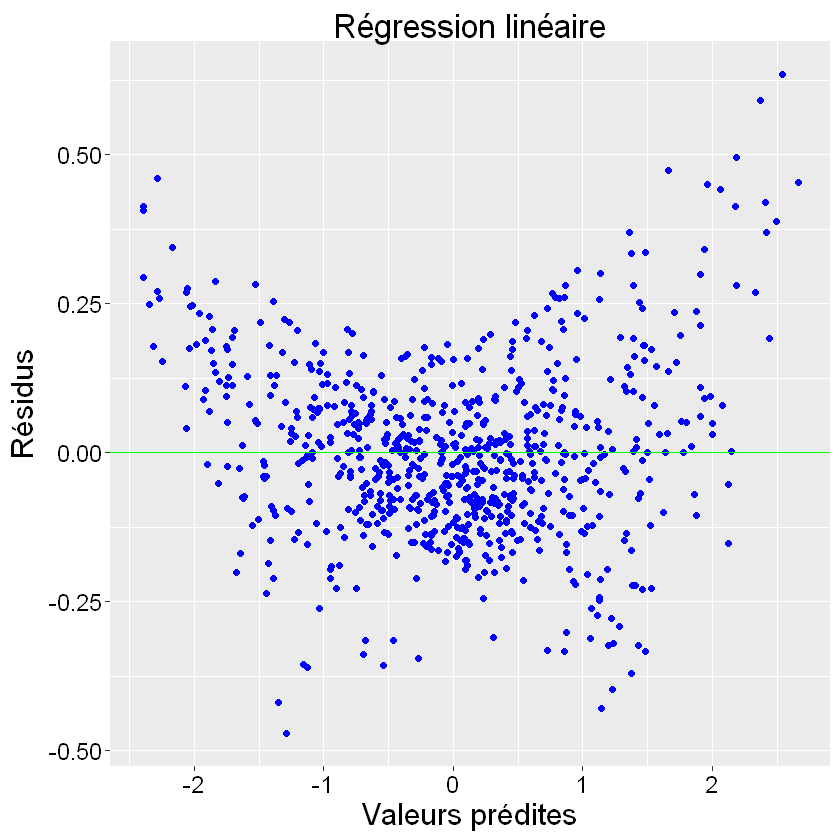

In [4]:
reg.lm <- lm(Calories_Burned ~ ., data = gym_train_scaled)

# Summary of the regression
summary(reg.lm)

# Extract the residuals
sel.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values

# Plot the residuals
gplot.res(fit.lm, sel.lm, "Régression linéaire")

In [5]:
# MSE of the model on the training and test set
mse_train <- mean(sel.lm^2)
mse_test <- mean((predict(reg.lm, gym_test_scaled) - gym_test_scaled$Calories_Burned)^2)

cat("MSE on training set: ", mse_train, "\n")
cat("MSE on test set: ", mse_test, "\n")

MSE on training set:  0.02144403 
MSE on test set:  0.01608908 


**Interprétation** : Giga trompette, on va rajouter des termes quadratiques

#### LASSO

,Age,GenderFemale,GenderMale,LWeight,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Workout_TypeHIIT,Workout_TypeStrength,Workout_TypeYoga,SFat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.3,Workout_Frequency..days.week.4,Workout_Frequency..days.week.5,Experience_Level2,Experience_Level3
2,0.58677041,1,0,0.19779559,-1.5050986225,-0.06617008,0.4802851,0.5262388,0.11582778,1,0,0,-1.7625553,-0.8567881,0,1,0,1,0
3,-0.55678178,1,0,-0.14540416,-0.4751551297,-1.10054779,-1.5271377,-1.1206579,-0.43523841,0,0,0,-1.5948489,-0.5262097,0,1,0,1,0
5,-0.06668799,0,1,-1.55230634,0.5547883631,0.70961321,0.9648354,0.8007216,-1.79840214,0,1,0,-0.5728511,0.3002366,1,0,0,0,0
6,1.40359340,1,0,-0.72427809,-0.3167022846,-1.01434964,0.8263925,1.6241700,0.95692880,1,0,0,1.3988024,0.1349473,0,0,1,0,1
7,-0.23005259,0,1,-0.03075534,0.0002034054,-0.49716079,1.7262717,1.4869286,0.66689396,0,0,0,0.6865113,-0.5262097,1,0,0,1,0
8,0.09667661,1,0,-0.06166344,-1.6635514675,0.79581135,-0.2119297,0.2517560,0.02881733,0,0,0,-0.8643778,-1.1873666,1,0,0,1,0


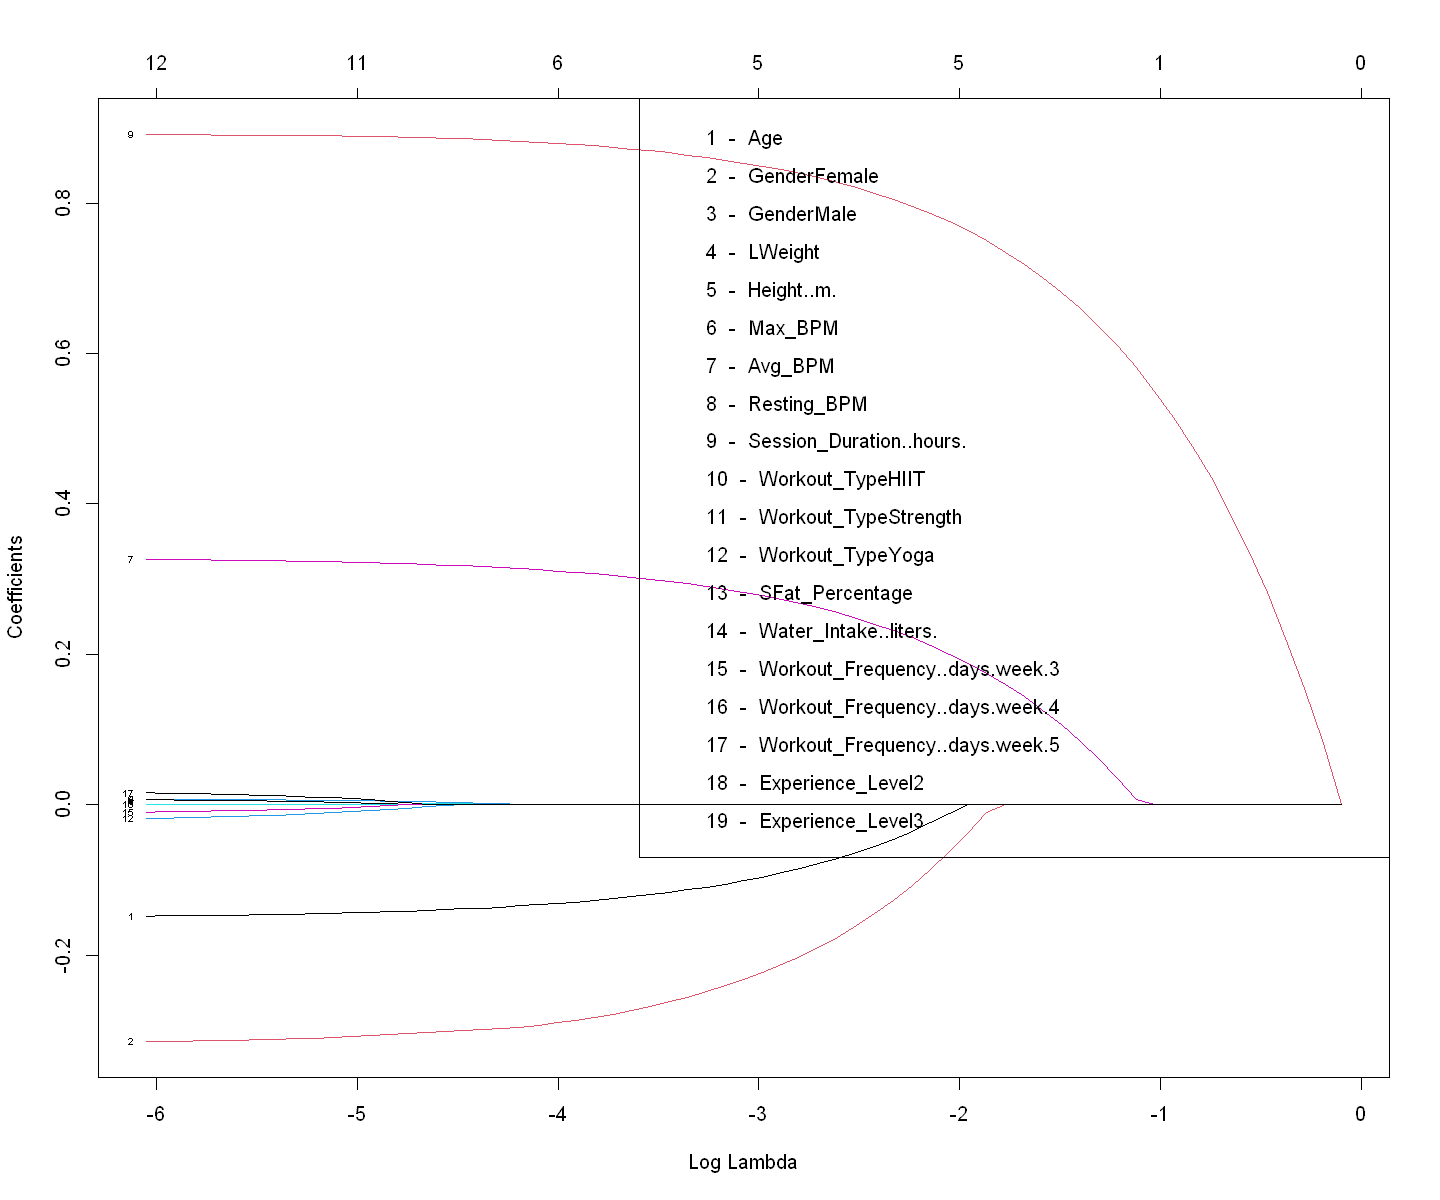

In [6]:
x.mat <- model.matrix(Calories_Burned ~ . -1, data = gym_train_scaled)
y.vec <- gym_train_scaled$Calories_Burned

head(x.mat)

# Fit the lasso model
reg.lasso <- glmnet(x.mat, y.vec, alpha = 1, nfolds = 10) # alpha = 1 for lasso

# Plot the coefficients
options(repr.plot.width=12, repr.plot.height=10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))



Call:  cv.glmnet(x = x.mat, y = y.vec, nfolds = 10, alpha = 1) 

Measure: Mean-Squared Error 

      Lambda Index Measure       SE Nonzero
min 0.003417    61 0.02257 0.002322      10
1se 0.024106    40 0.02476 0.003223       5

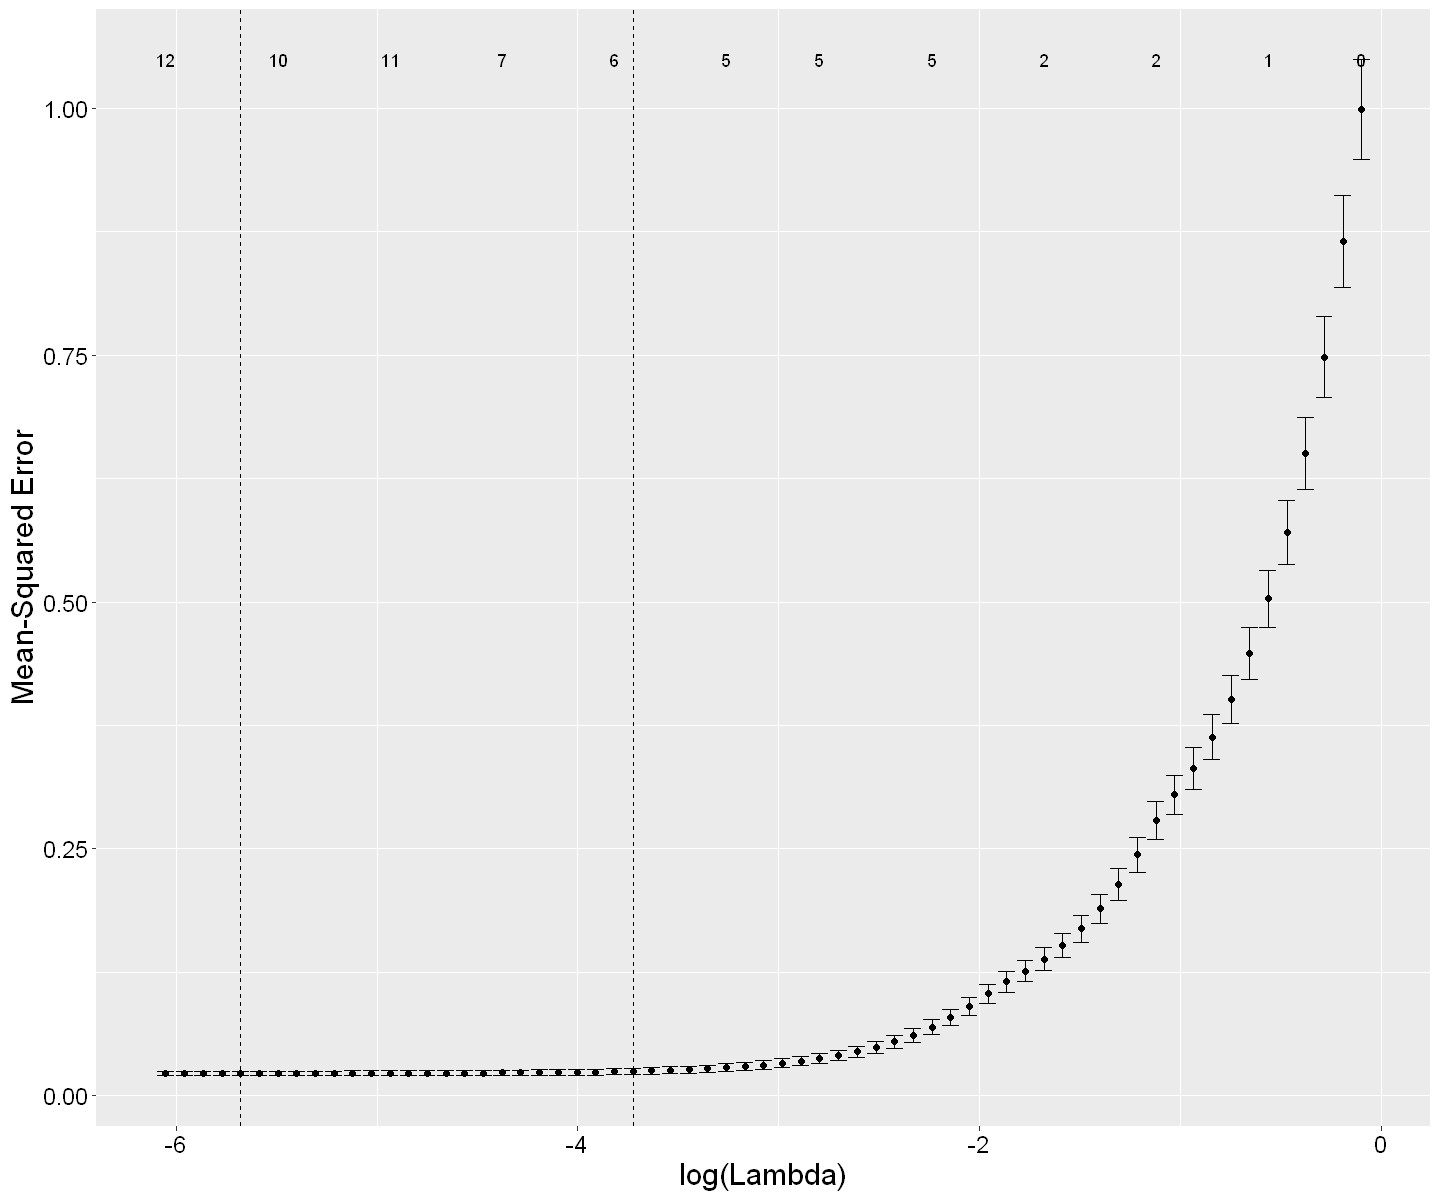

In [7]:
# Cross-validation
reg.lasso.cv <- cv.glmnet(x.mat, y.vec, alpha = 1, nfolds = 10)
reg.lasso.cv
autoplot(reg.lasso.cv)

In [8]:
cat("Best lambda: ", round(reg.lasso.cv$lambda.min,5), "\t \t")
cat("MSE for best lambda: ", round(reg.lasso.cv$cvm[which.min(reg.lasso.cv$cvm)],5), "\n")
cat("Best lambda 1se: ", round(reg.lasso.cv$lambda.1se,5), "\t")
cat("MSE for best lambda 1se: ", round(reg.lasso.cv$cvm[which.min(reg.lasso.cv$cvm)],5), "\n")


# Extract the best model
coef(reg.lasso.cv, s = "lambda.1se")

Best lambda:  0.00342 	 	MSE for best lambda:  0.02257 
Best lambda 1se:  0.02411 	MSE for best lambda 1se:  0.02257 


20 x 1 sparse Matrix of class "dgCMatrix"
                                          s1
(Intercept)                     1.372096e-01
Age                            -1.250175e-01
GenderFemale                   -2.783496e-01
GenderMale                      3.172129e-14
LWeight                         .           
Height..m.                      .           
Max_BPM                         .           
Avg_BPM                         3.048149e-01
Resting_BPM                     .           
Session_Duration..hours.        8.740339e-01
Workout_TypeHIIT                .           
Workout_TypeStrength            .           
Workout_TypeYoga                .           
SFat_Percentage                 .           
Water_Intake..liters.           .           
Workout_Frequency..days.week.3  .           
Workout_Frequency..days.week.4  .           
Workout_Frequency..days.week.5  .           
Experience_Level2               .           
Experience_Level3               .           

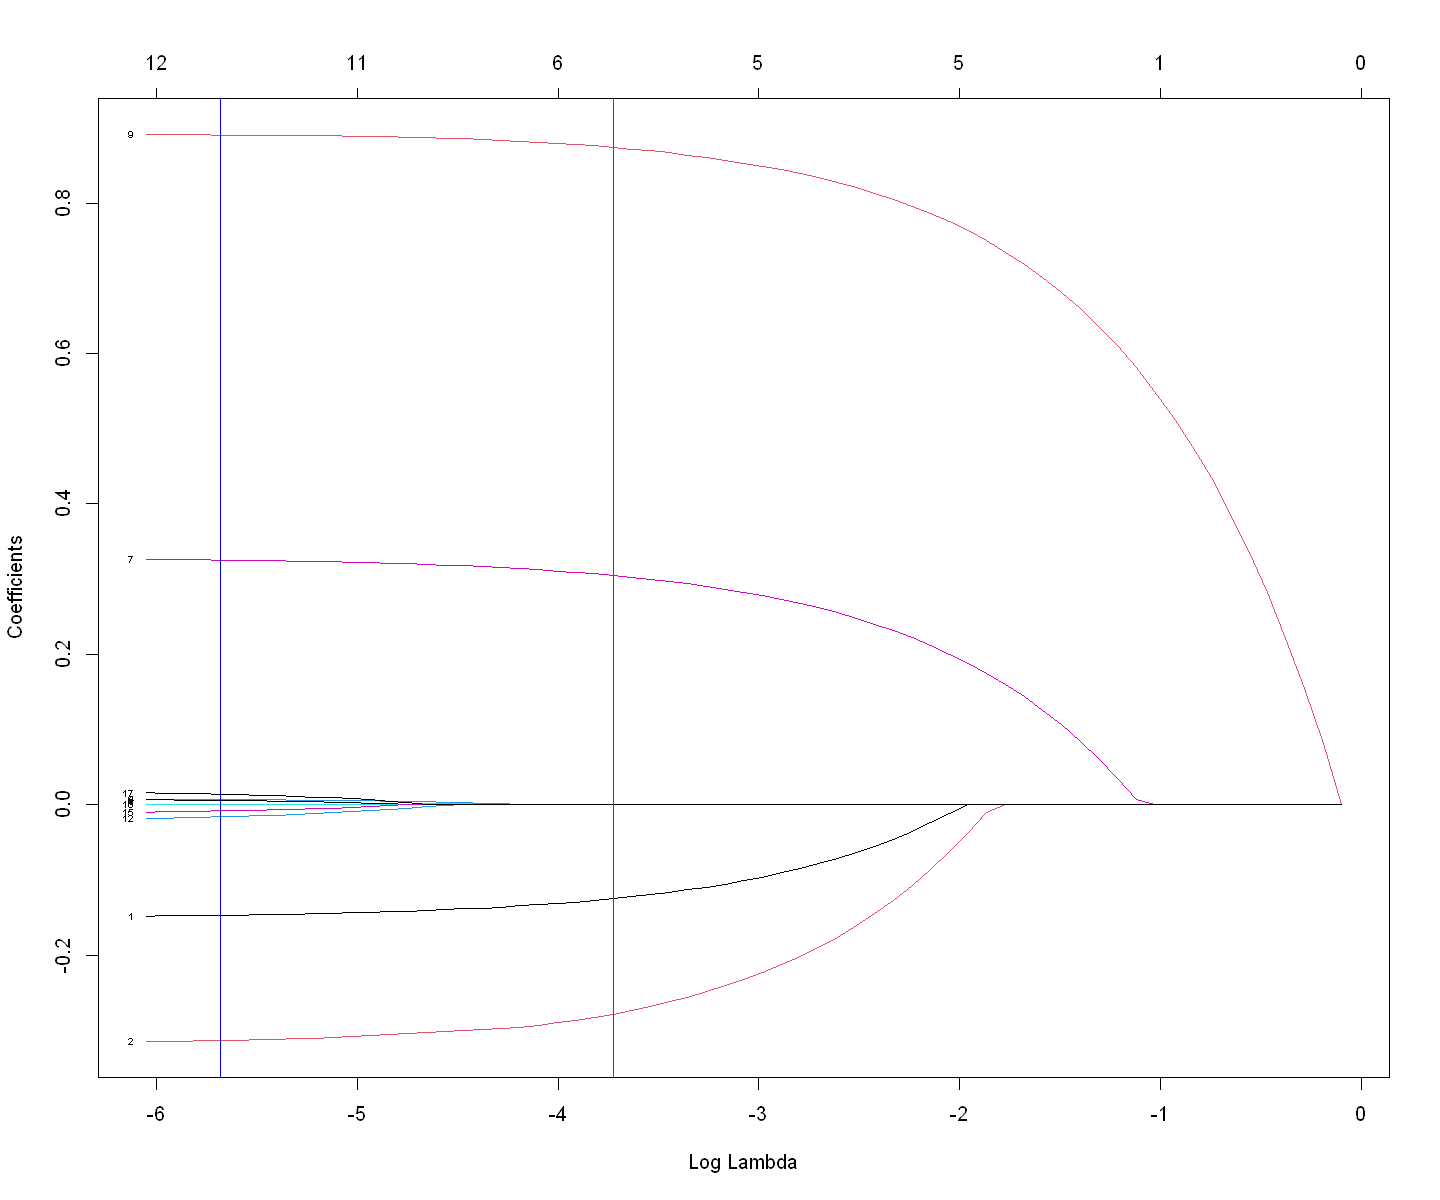

In [9]:
plot(reg.lasso, xvar = "lambda", label = TRUE)
abline(v=log(reg.lasso.cv$lambda.1se),col="red")
abline(v=log(reg.lasso.cv$lambda.min),col="blue")

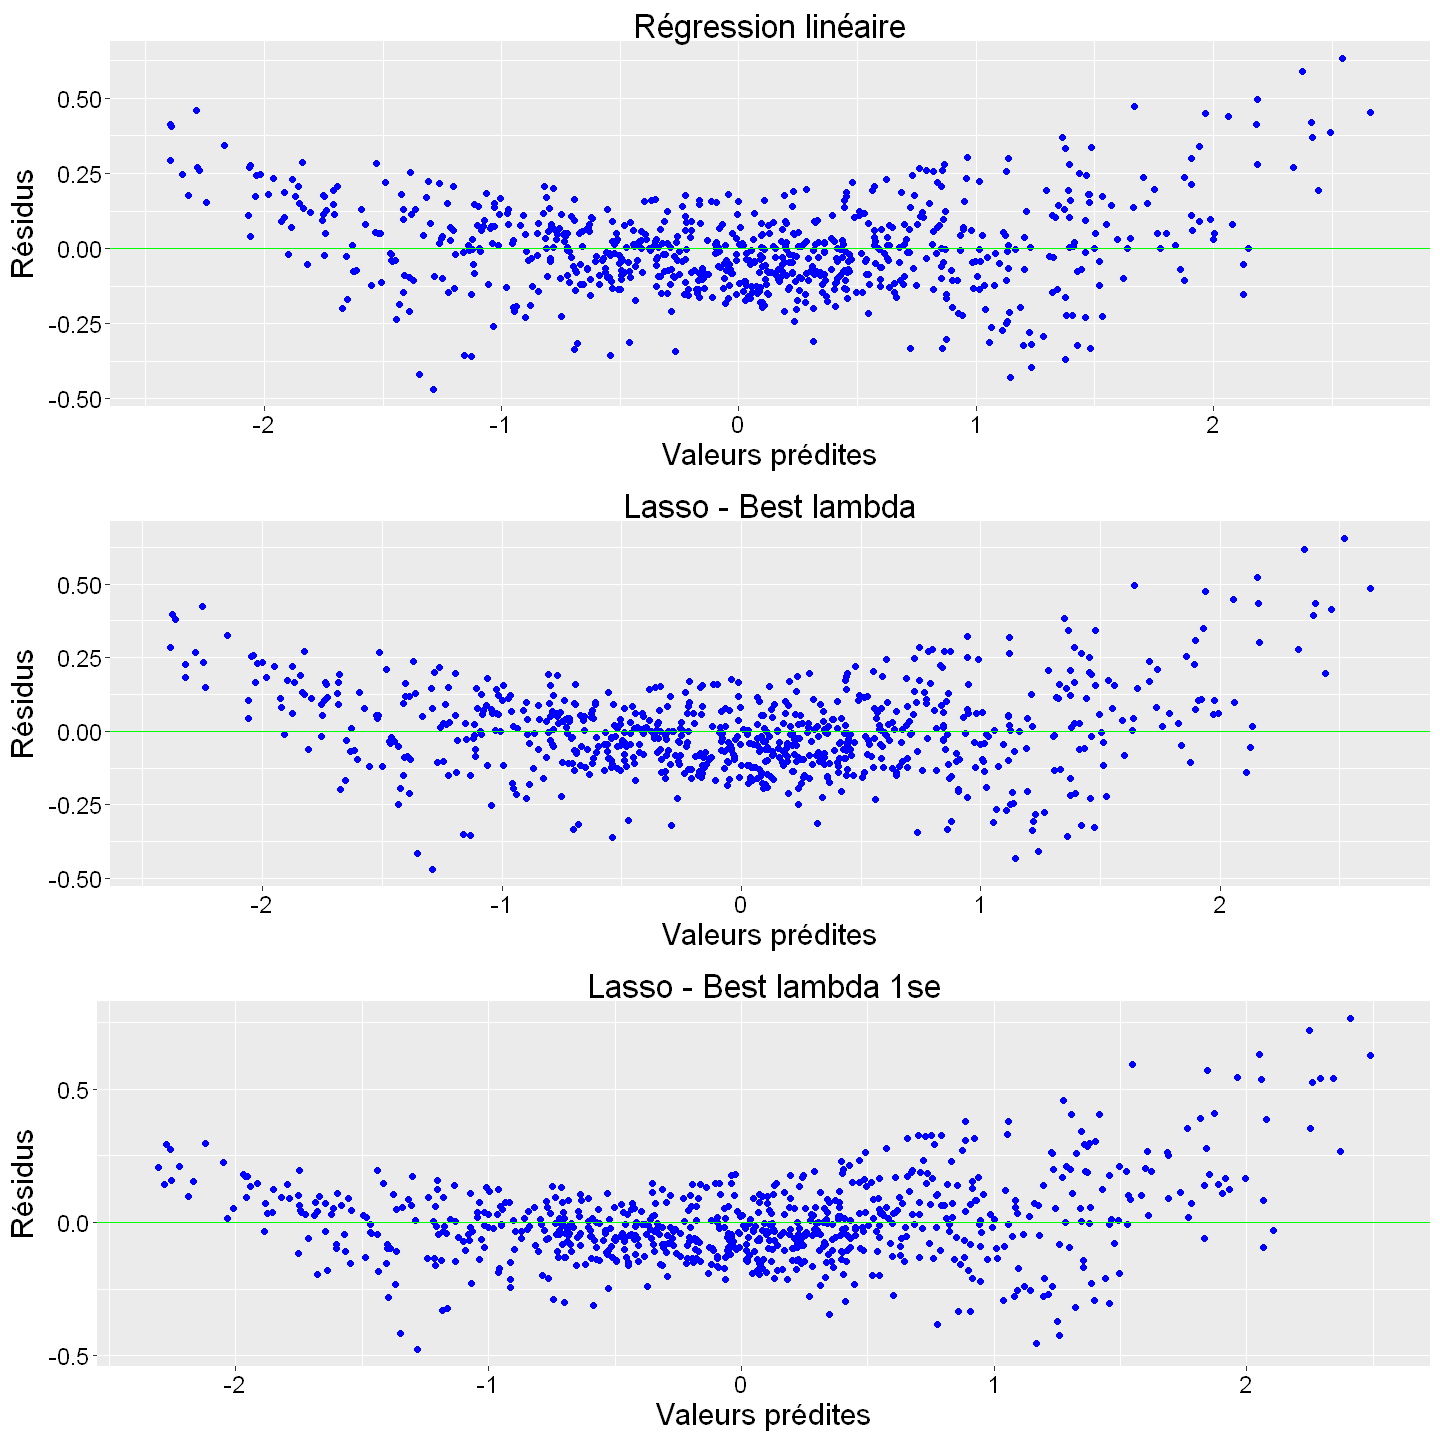

In [10]:
# Extract fitted values and residuals
fit.lasso.min <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso.min <- y.vec - fit.lasso.min

fit.lasso.1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat)
res.lasso.1se <- y.vec - fit.lasso.1se

# Plot the residuals
options(repr.plot.width=12, repr.plot.height=12)
p0 <- gplot.res(fit.lm, sel.lm, "Régression linéaire")
p1 <- gplot.res(fit.lasso.min, res.lasso.min, "Lasso - Best lambda")
p2 <- gplot.res(fit.lasso.1se, res.lasso.1se, "Lasso - Best lambda 1se")

grid.arrange(p0, p1, p2, ncol = 1)
rm(p0, p1, p2)

### Modèle Quadratique

In [11]:
# Quadratic model with lasso
x.mat.quad <- model.matrix(Calories_Burned ~ .^2 -1, data = gym_train_scaled)
reg.lasso.quad.cv <- cv.glmnet(x.mat.quad, y.vec, alpha = 1, nfolds = 10)
reg.lasso.quad.cv 
# coef(reg.lasso.quad.cv, s = "lambda.1se")


Call:  cv.glmnet(x = x.mat.quad, y = y.vec, nfolds = 10, alpha = 1) 

Measure: Mean-Squared Error 

      Lambda Index  Measure        SE Nonzero
min 0.002146    66 0.009141 0.0005331      61
1se 0.009508    50 0.009667 0.0006276      21

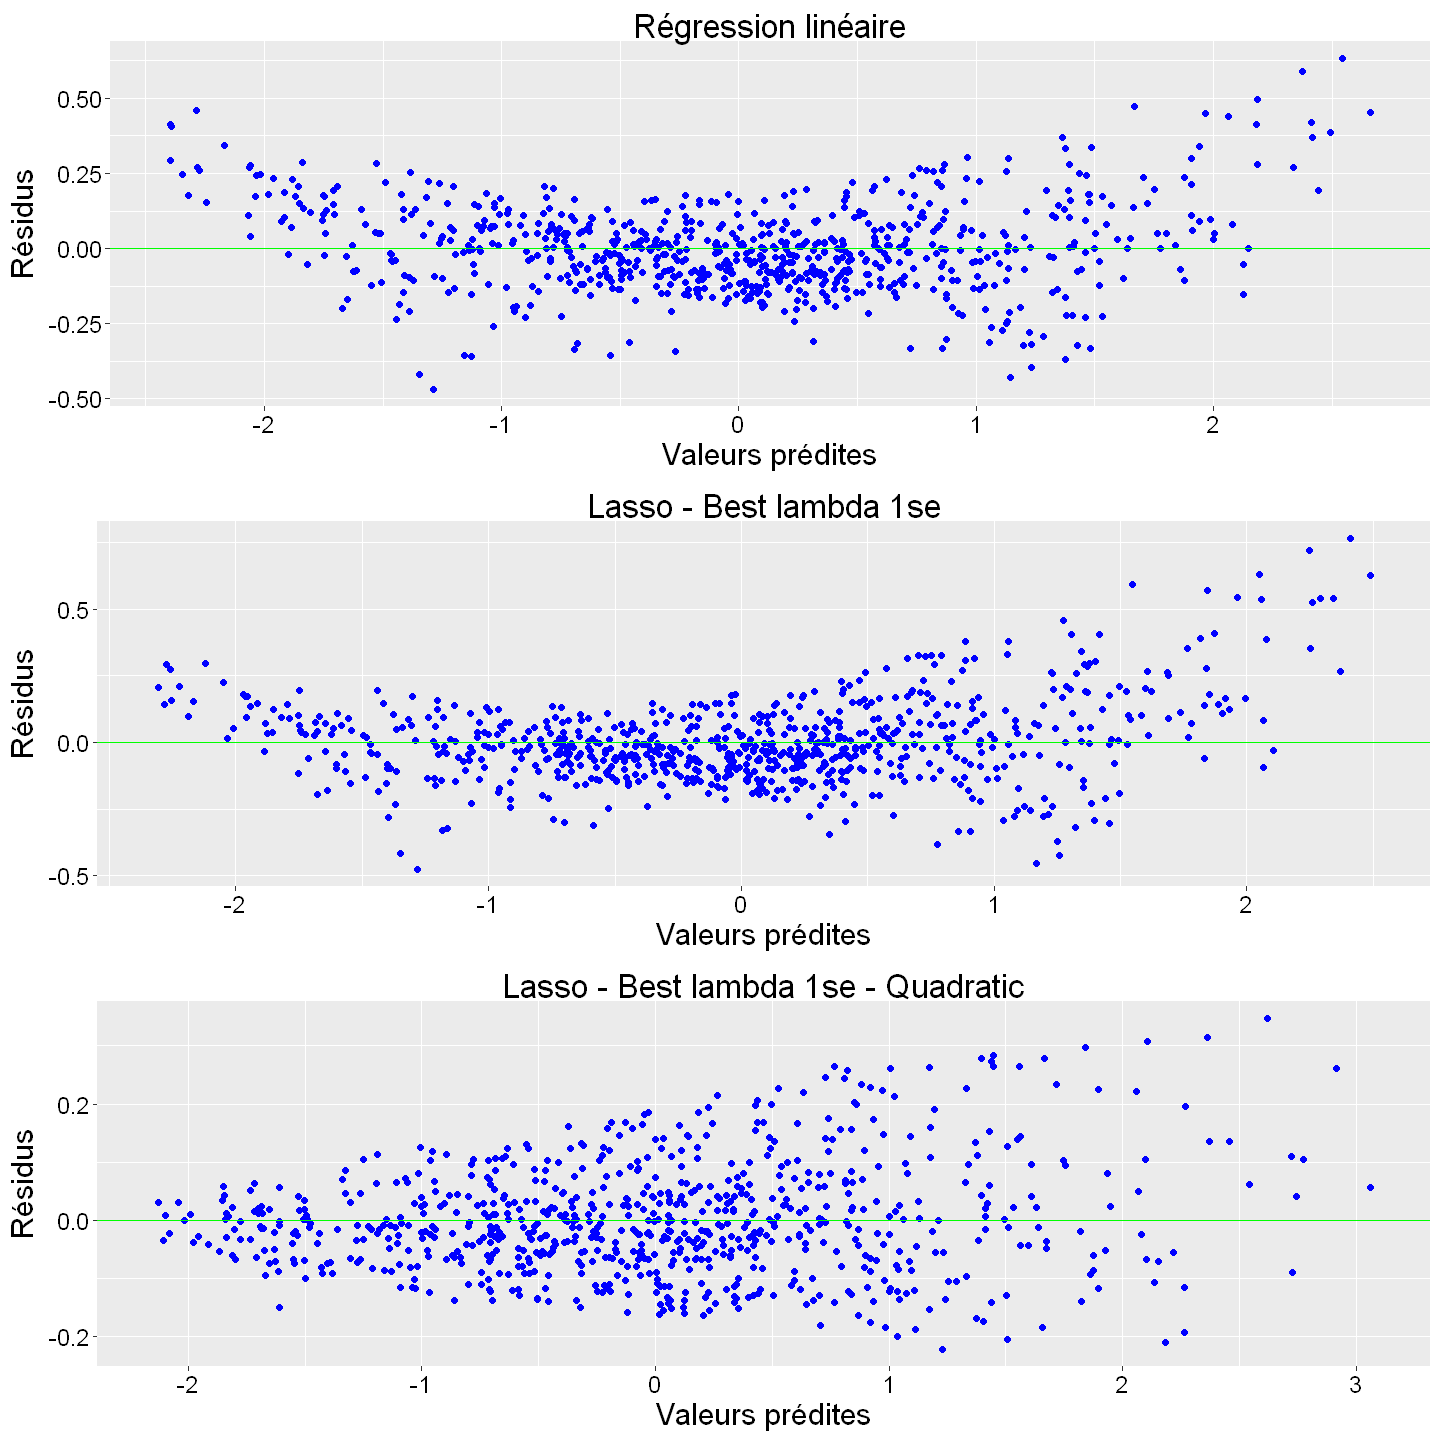

In [12]:
fit.lasso.quad.1se <- predict(reg.lasso.quad.cv, s = "lambda.1se", newx = x.mat.quad)
res.lasso.quad.1se <- y.vec - fit.lasso.quad.1se

# Plot the residuals
options(repr.plot.width=12, repr.plot.height=12)
p0 <- gplot.res(fit.lm, sel.lm, "Régression linéaire")
p1 <- gplot.res(fit.lasso.1se, res.lasso.1se, "Lasso - Best lambda 1se")
p2 <- gplot.res(fit.lasso.quad.1se, res.lasso.quad.1se, "Lasso - Best lambda 1se - Quadratic")

grid.arrange(p0, p1, p2, ncol = 1)
rm(p0, p1, p2)

### Support Vector Machines

In [13]:
library(e1071)

# SVM for regression
svm.reg0 <- svm(Calories_Burned ~ ., data = gym_train_scaled, cross = 5)
summary(svm.reg0)

Warning message:
"le package 'e1071' a été compilé avec la version R 4.4.3"
Warning message in cret$cresults * scale.factor:
"Le recyclage d’un tableau (array) de longueur 1 dans un calcul arithmétique vecteur-tableau est obsolète.
  Utilisez c() ou as.vector() à la place."



Call:
svm(formula = Calories_Burned ~ ., data = gym_train_scaled, cross = 5)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.05263158 
    epsilon:  0.1 


Number of Support Vectors:  317



5-fold cross-validation on training data:

Total Mean Squared Error: 0.02004878 
Squared Correlation Coefficient: 0.9803508 
Mean Squared Errors:
 0.02455288 0.01902644 0.01913765 0.01659293 0.02096286 





Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
       gamma cost
 0.003162278  100

- best performance: 0.009855978 


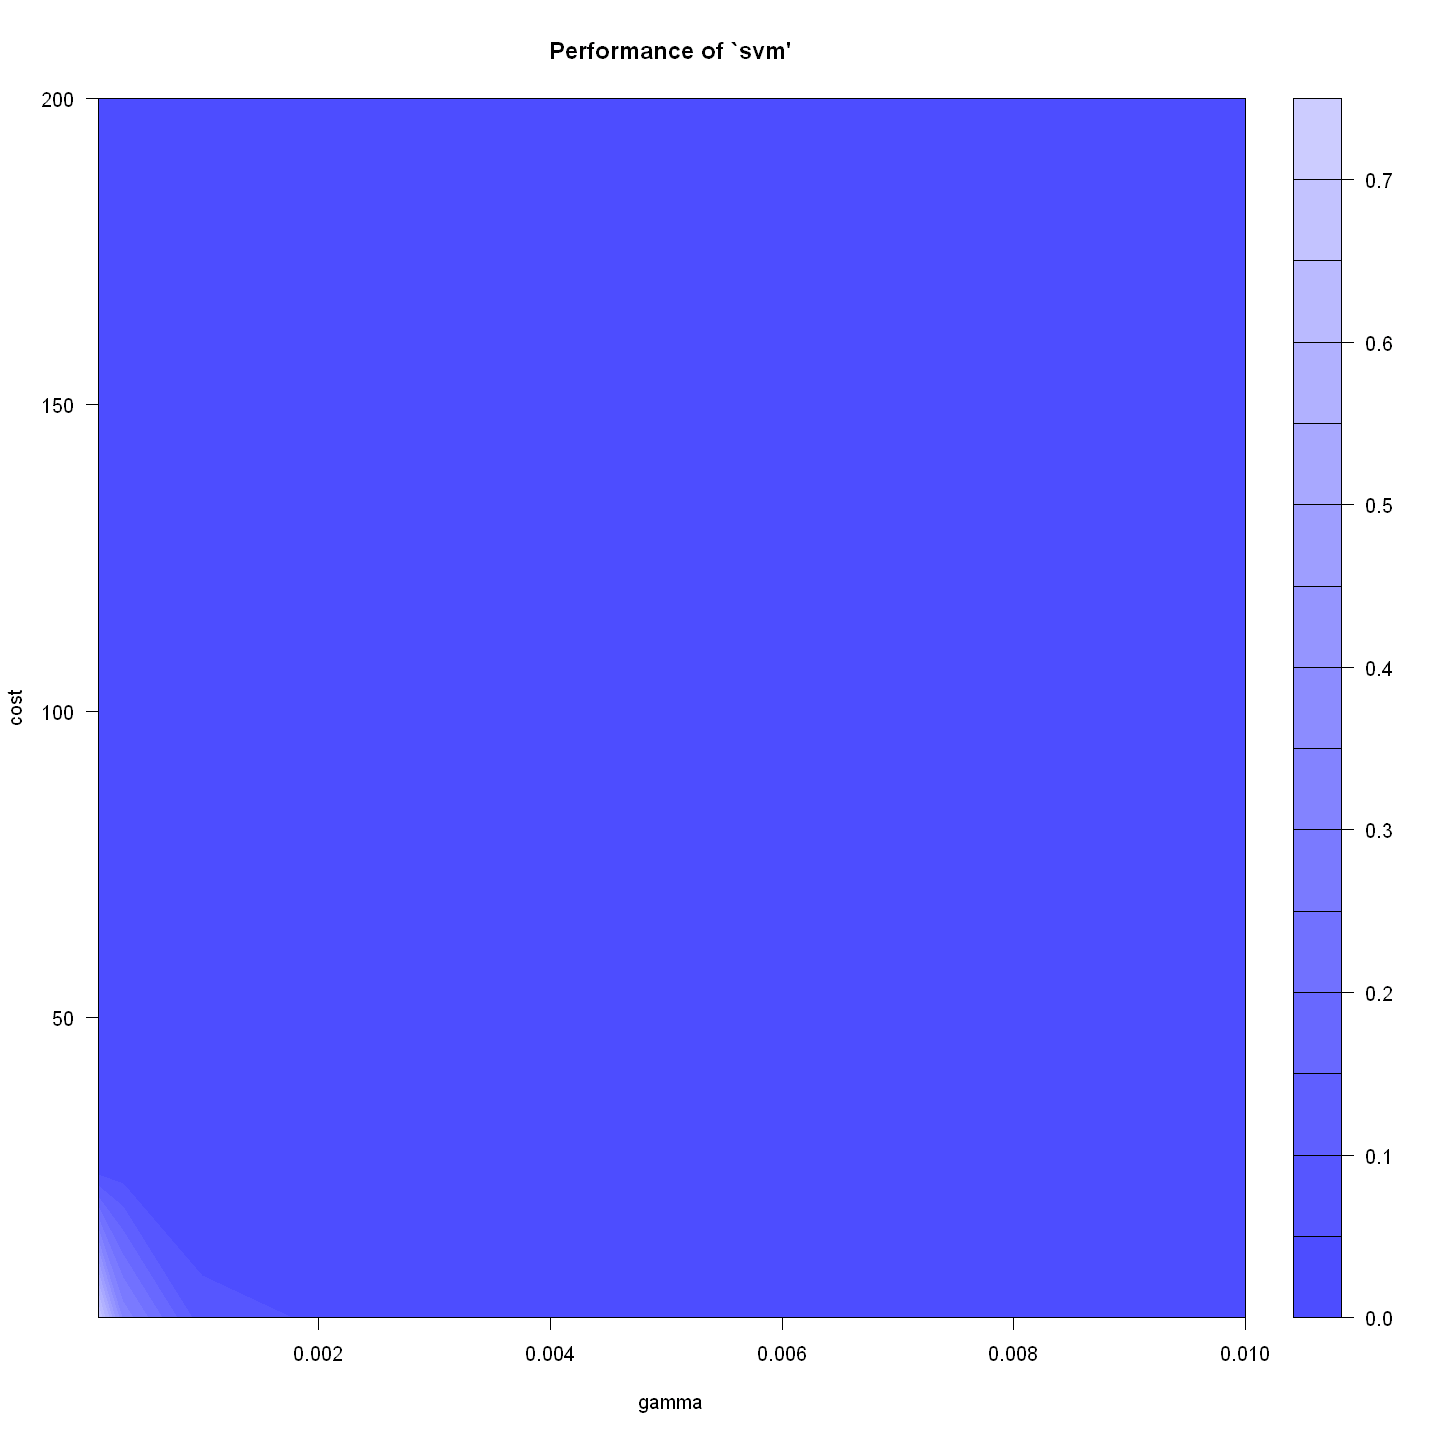

In [14]:
svm.reg.tune = tune.svm(Calories_Burned ~ ., data = gym_train_scaled, cost = c(1, 25, 50, 75, 100, 150, 200), 
    gamma = 10^seq(-4, -2, by = 0.5))
plot(svm.reg.tune)
svm.reg.tune

In [15]:
svm.reg.tune


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
       gamma cost
 0.003162278  100

- best performance: 0.009855978 


In [16]:
# Best model
svm.reg <- svm.reg.tune$best.model

# Predictions
pred.svm.reg <- predict(svm.reg, newdata=gym_test_scaled)

# Evaluate the model
cat("SVM Regression Model\n")
cat("MSE on test set: ", mean((gym_test_scaled$Calories_Burned - pred.svm.reg)^2), "\n")

SVM Regression Model
MSE on test set:  0.00822369 


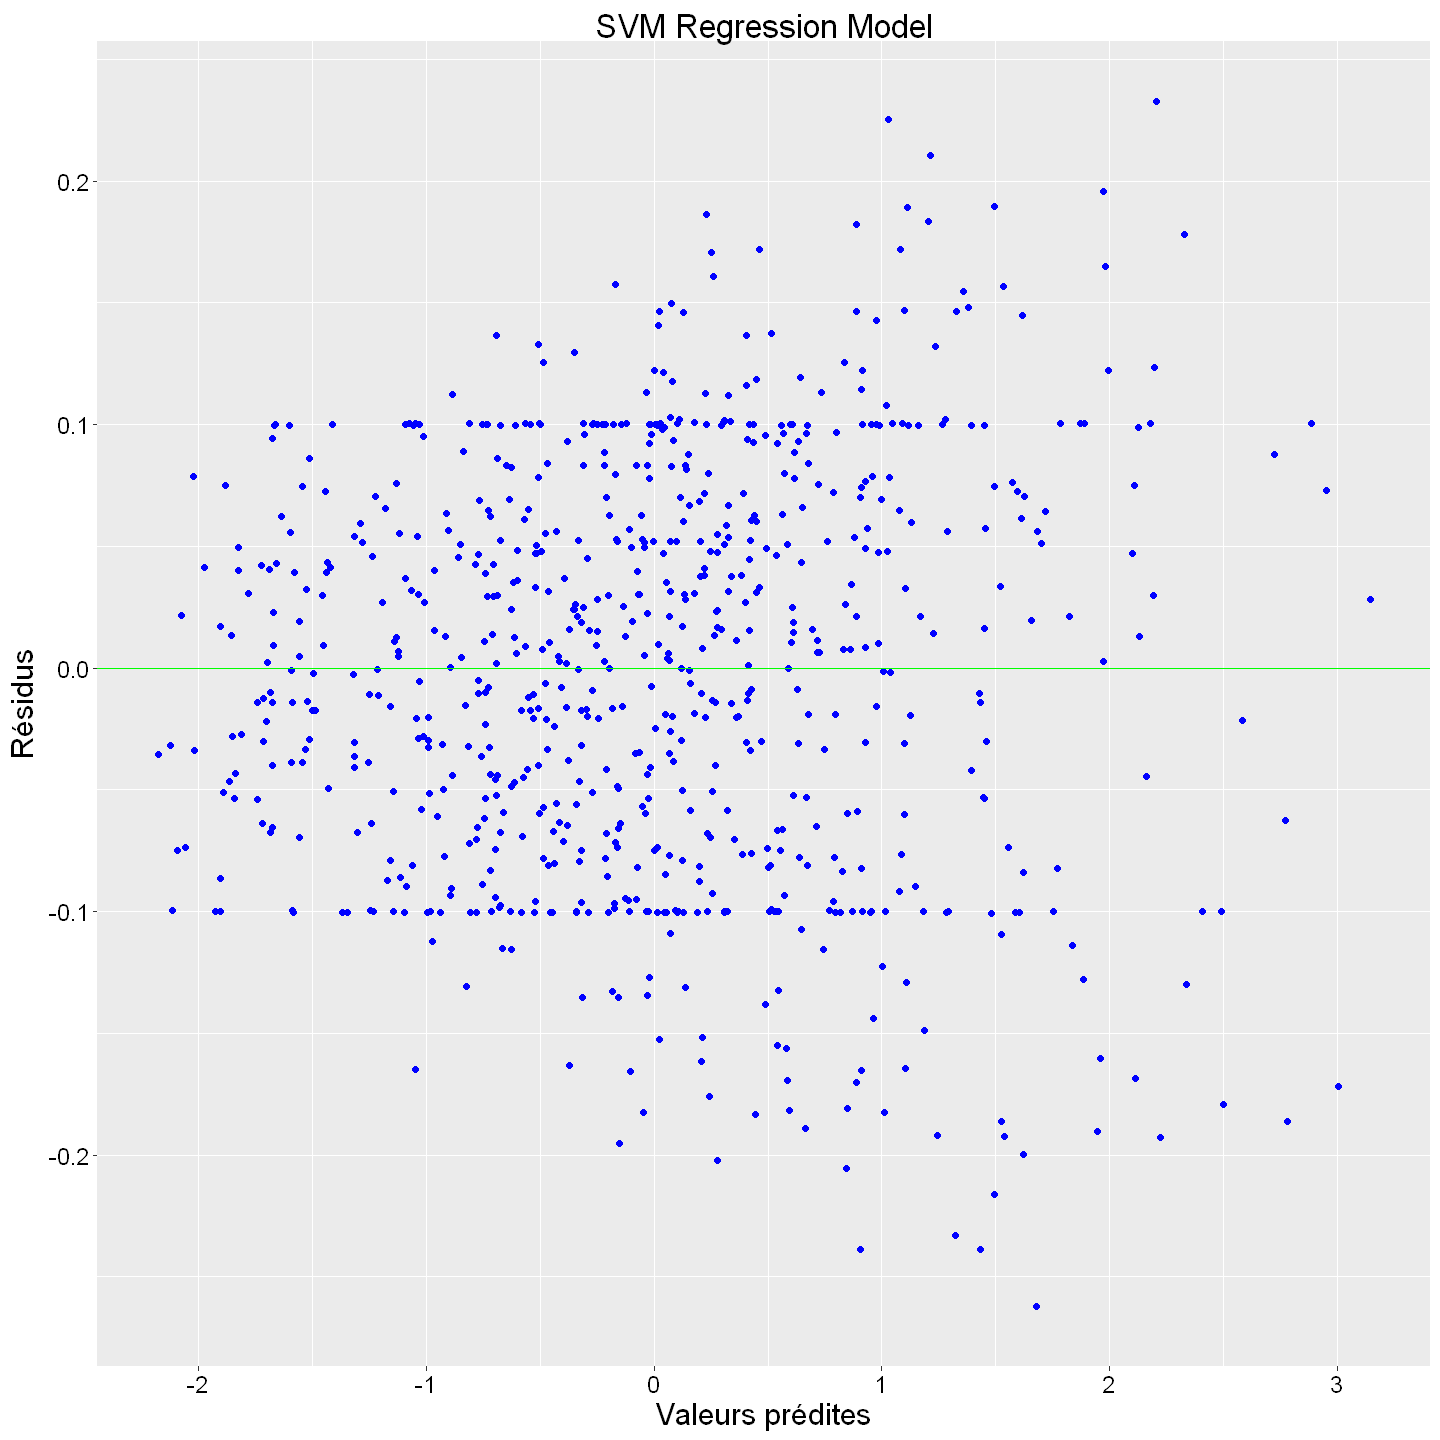

In [17]:
# graphe des résidus
fit.svm.reg = svm.reg$fitted
res.svm.reg = fit.svm.reg - gym_train_scaled$Calories_Burned
gplot.res(fit.svm.reg, res.svm.reg, "SVM Regression Model")

### Regression Trees

- Fit a decision tree regressor.
- Prune the tree using cross-validation.
- Plot: Decision tree structure.

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


MSE on training set:  2613.292 
MSE on test set:  4521.336 
R2 on training set:  0.9655021 
R2 on test set:  0.9342961 


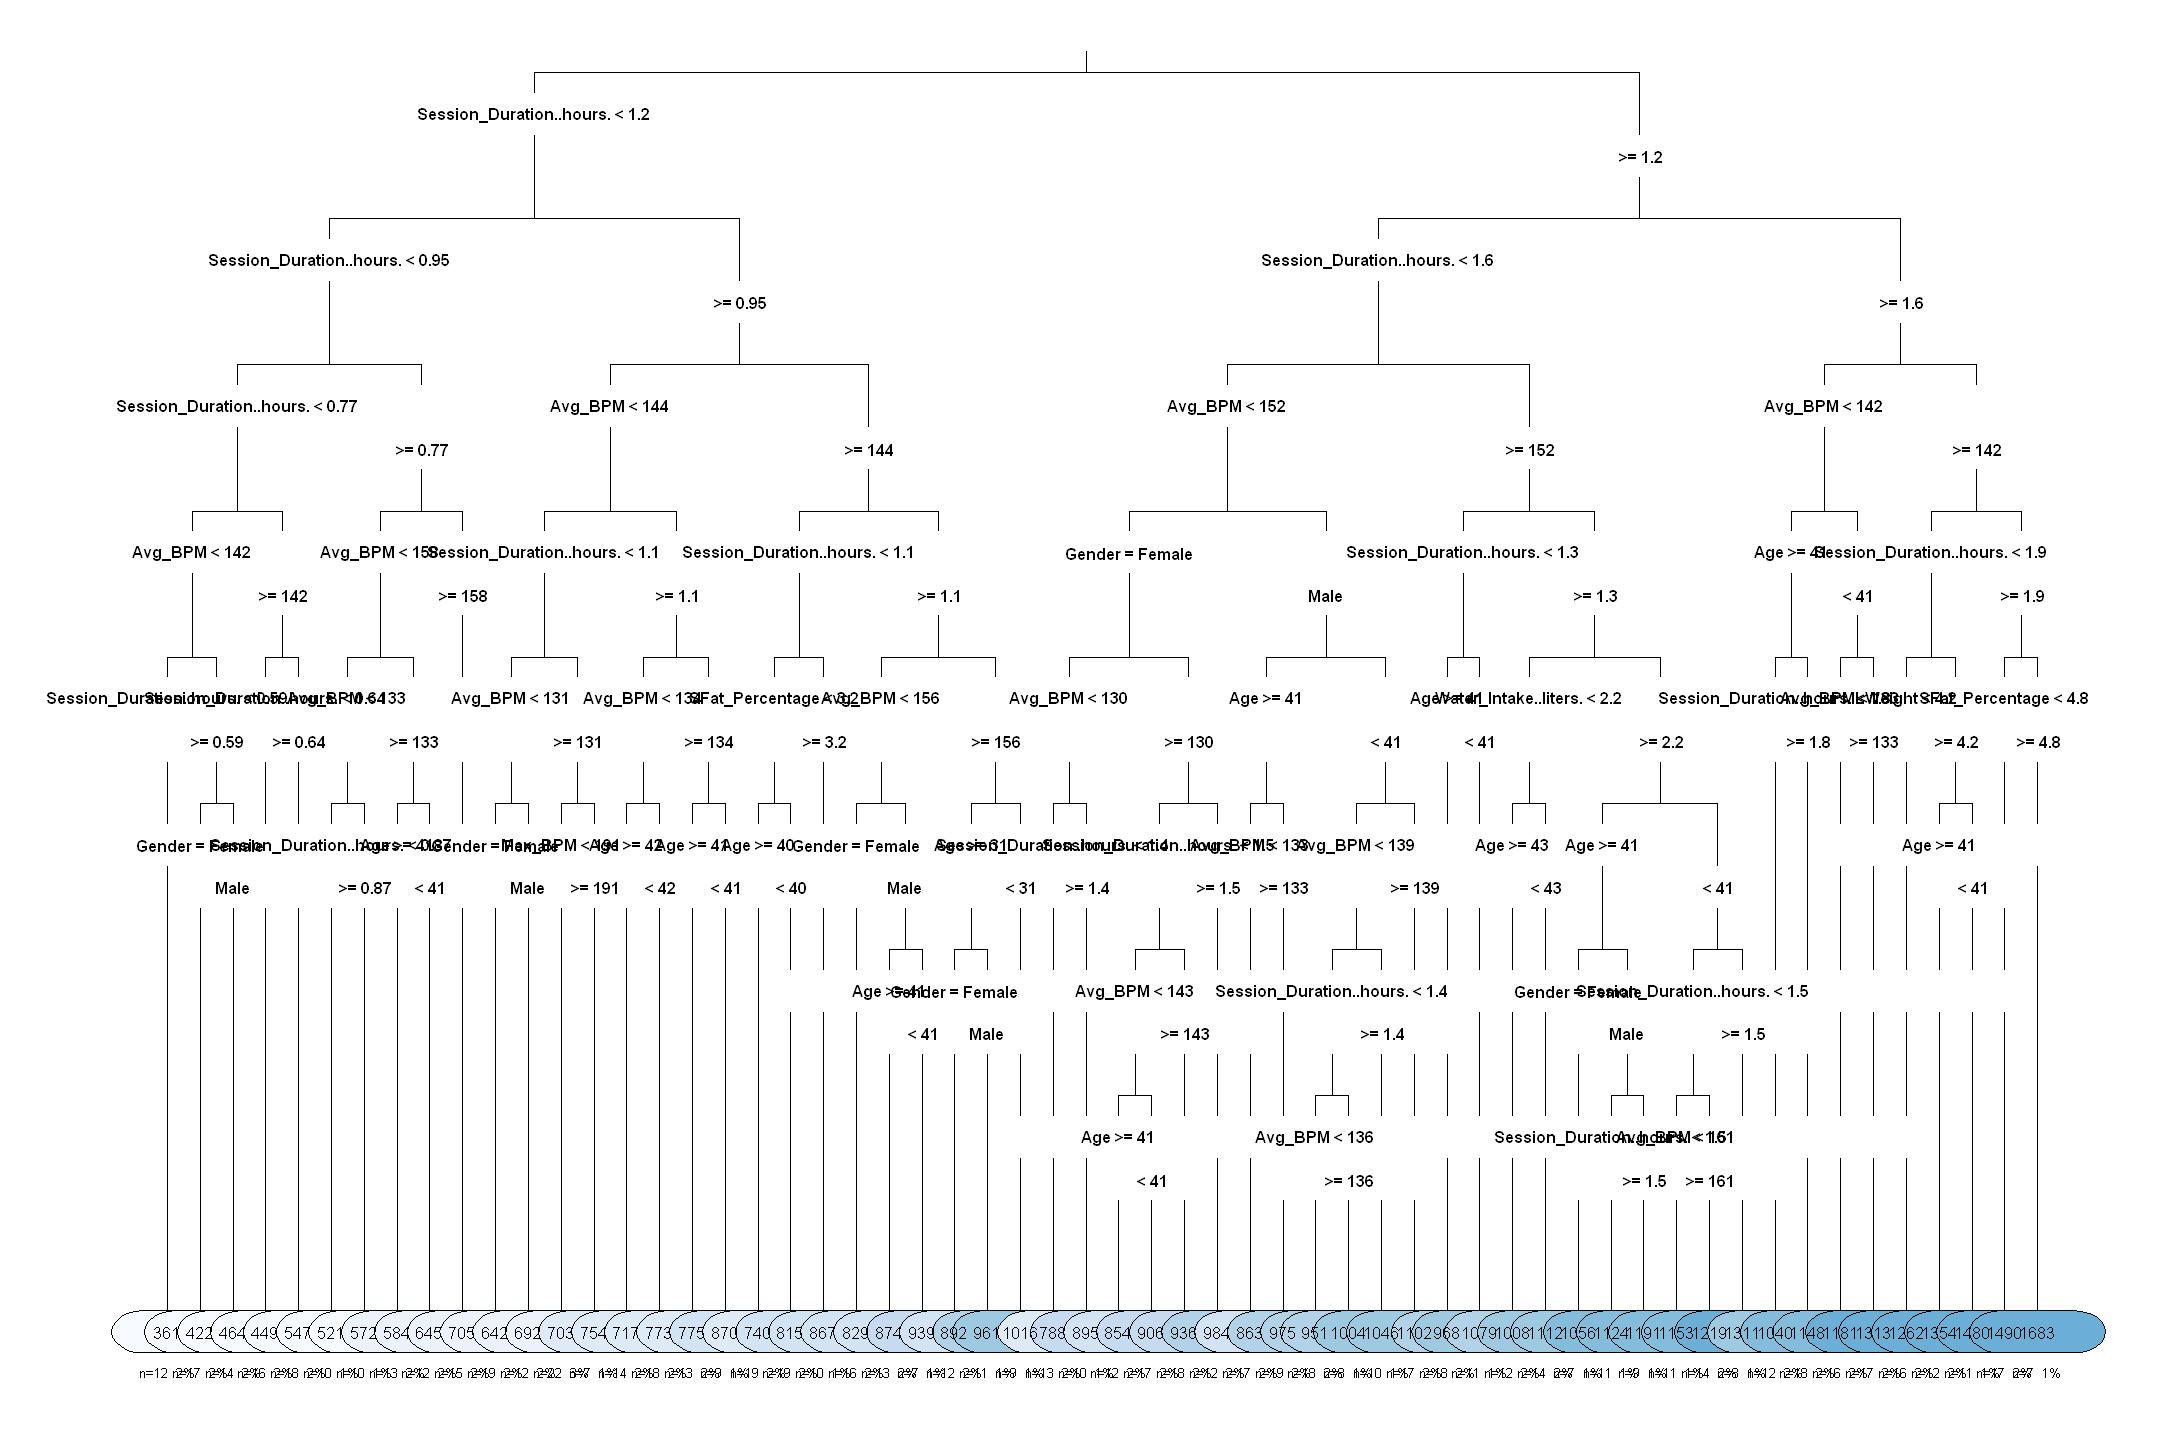

In [121]:
# Fit a regression tree model
library(rpart)
library(rpart.plot)

# Fit a regression tree model for Calories_Burned
tree.reg.cal <- rpart(Calories_Burned ~ ., data = gym_train, control=rpart.control(cp=0.0001))

options(repr.plot.width=18, repr.plot.height=12)
# Plot the tree
rpart.plot(tree.reg.cal, extra = 101, type = 3, under = TRUE, cex = 0.8, tweak = 1)

# summary(tree.reg.cal)

# compute MSE and R2 on training and test sets
mse_train <- mean((gym_train$Calories_Burned - predict(tree.reg.cal, gym_train))^2)
mse_test <- mean((gym_test$Calories_Burned - predict(tree.reg.cal, gym_test))^2)
r2_train <- 1 - mse_train / var(gym_train$Calories_Burned)
r2_test <- 1 - mse_test / var(gym_test$Calories_Burned)
cat("MSE on training set: ", mse_train, "\n")
cat("MSE on test set: ", mse_test, "\n")
cat("R2 on training set: ", r2_train, "\n")
cat("R2 on test set: ", r2_test, "\n")

**Interprétation** : Nous avons initialement construit un arbre de régression avec un paramètre de complexité extrêmement faible (`cp = 0.0001`). Comme attendu, ce modèle présente une structure profondément ramifiée (58 feuilles), caractéristique d'un sur-apprentissage. Ce modèle présente une performance relativement bonne sur le jeu d’entraînement (R² = 0.966, MSE = 2613), mais un écart significatif entre l’erreur d’entraînement et de test (MSE_test = 4521) révèle un sur-apprentissage. Toutefois, le R² sur le test reste élevé (0.934), indiquant que le modèle capture une part substantielle de la variance explicative, malgré sa complexité excessive.

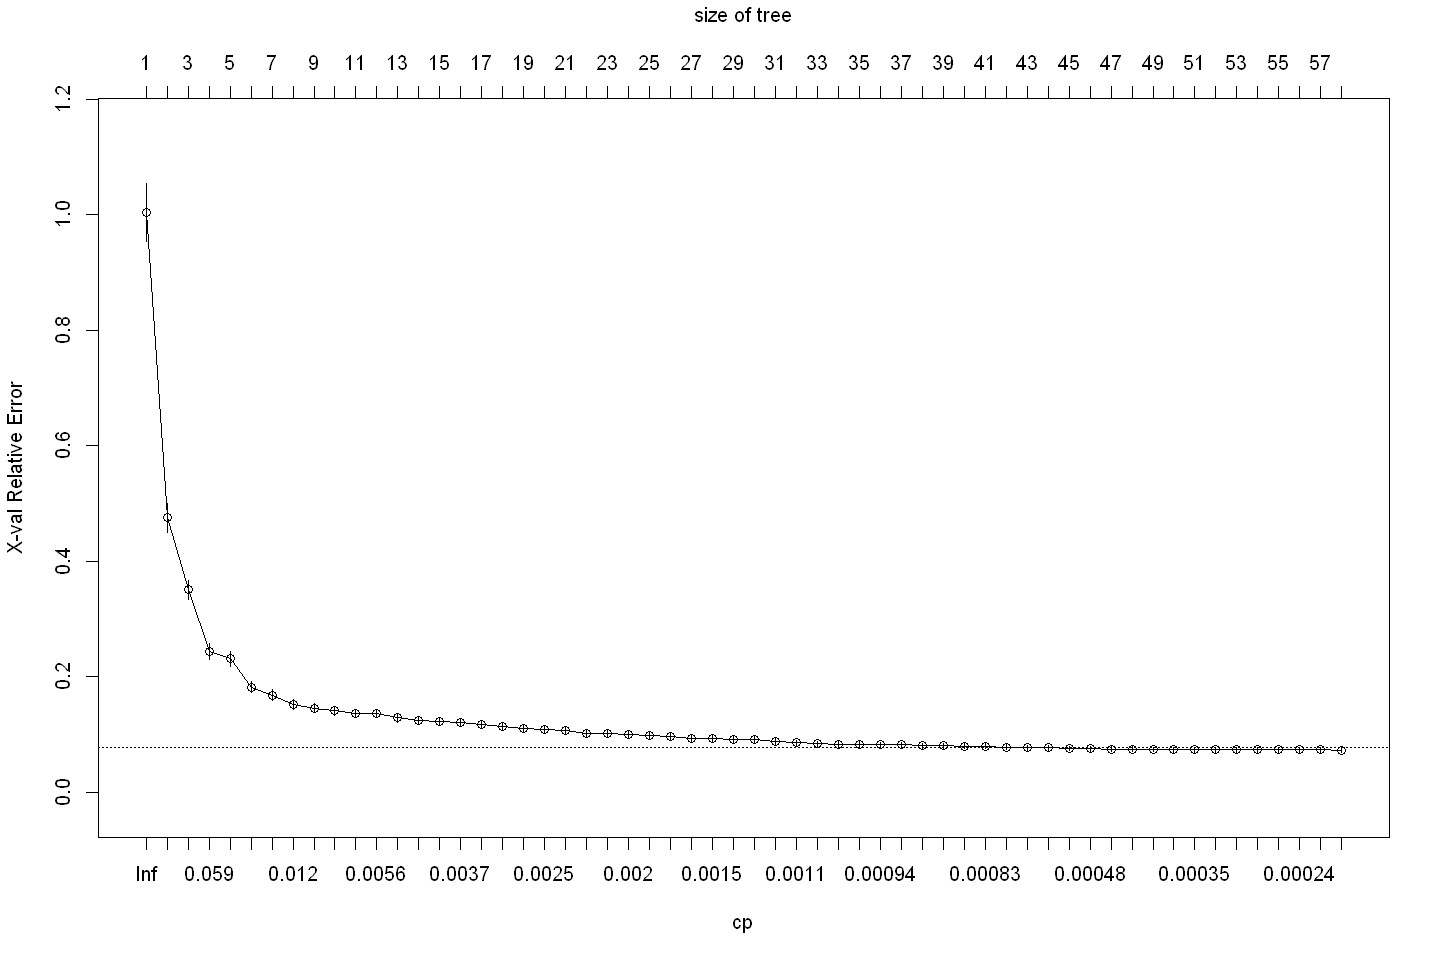

In [95]:
options(repr.plot.width=12, repr.plot.height=8)

xmat = xpred.rpart(tree.reg.cal, xval = 10)

CVerr<-apply((xmat-gym_train[,"Calories_Burned"])^2,2,sum)

plotcp(tree.reg.cal)

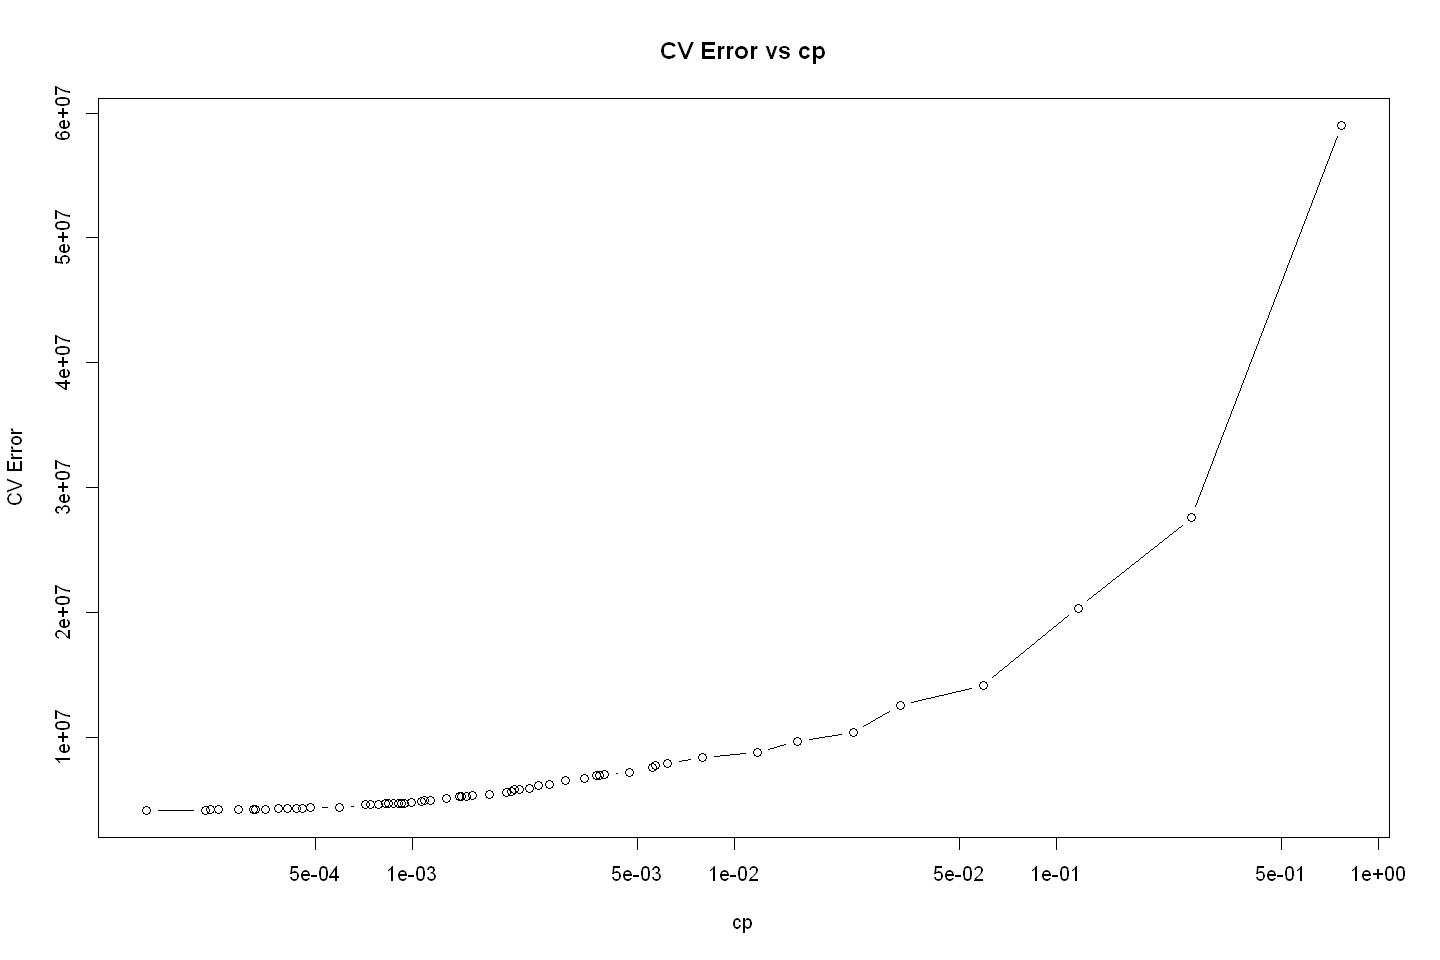

In [96]:
plot(as.numeric(names(CVerr)), CVerr, type = "b", xlab = "cp", ylab = "CV Error", main = "CV Error vs cp", log = "x")

[1] 0.0001485483

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


Number of nodes:  115 


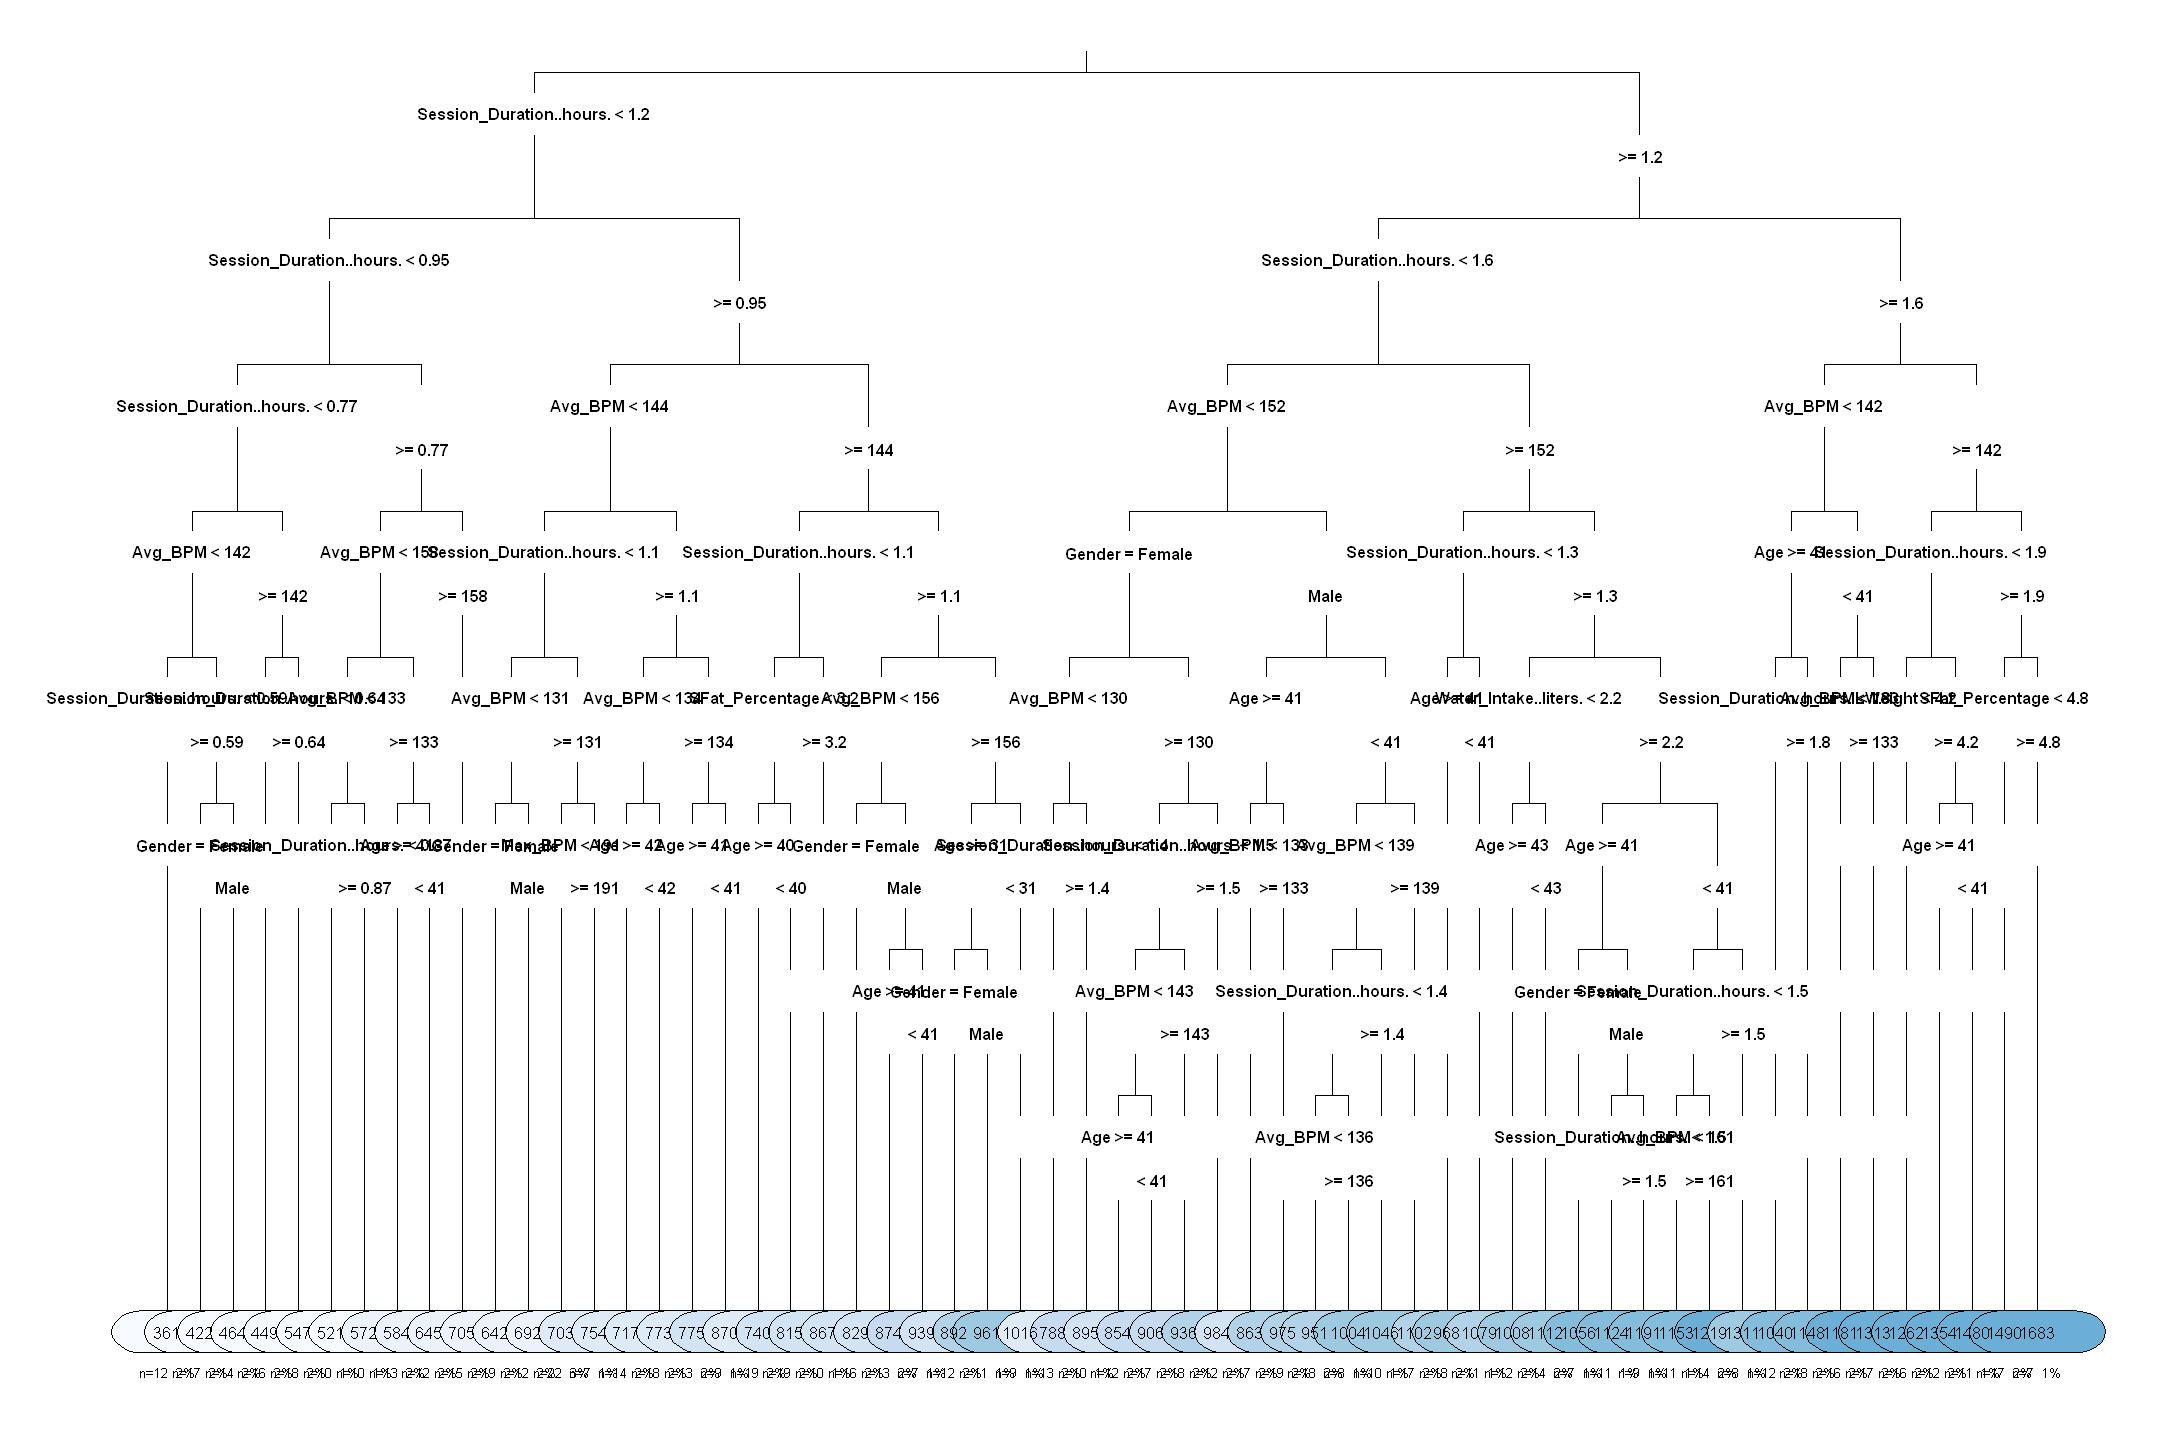

In [126]:
options(repr.plot.width=18, repr.plot.height=12)
as.numeric(attributes(which.min(CVerr))$names)
tree.reg.cal <- rpart(Calories_Burned ~ ., data = gym_train, control=rpart.control(cp=as.numeric(attributes(which.min(CVerr))$names)))

# Plot the tree
rpart.plot(tree.reg.cal, extra = 101, type = 3, under = TRUE, cex = 0.8, tweak = 1)

# display the number of nodes of the treee
cat("Number of nodes: ", length(tree.reg.cal$frame$var), "\n")

**Interprétation** : La validation croisée 10-fold a identifié une pénalité optimale inattendue (`cp ≈ 0.00015`), conduisant à une erreur de validation (MSE ≈ 4521) inférieure aux modèles moins complexes. Ce résultat paradoxal – où réduire `cp` améliore la performance en validation – pourrait s'expliquer par:
- La présence d'interactions complexes dans les données, nécessitant une structure arborescente fine pour être capturées,
- Un biais de sélection lié à l'échantillon, où le sur-apprentissage partiel reste généralisable.

Le premier point est peu probable car le modèle de régression linéaire avec régularisation LASSO a déjà capturé la plupart des interactions significatives. Le second point est plus plausible, suggérant que le modèle a appris des motifs spécifiques à l'échantillon d'entraînement qui se généralisent bien à la validation croisée.

Cependant, l'arbre résultant reste difficilement interprétable (115 nœuds), soulignant un compromis problématique entre performance et explicabilité.

In [103]:
# library(partykit)
# plot(as.party(tree.reg.cal), type="simple")

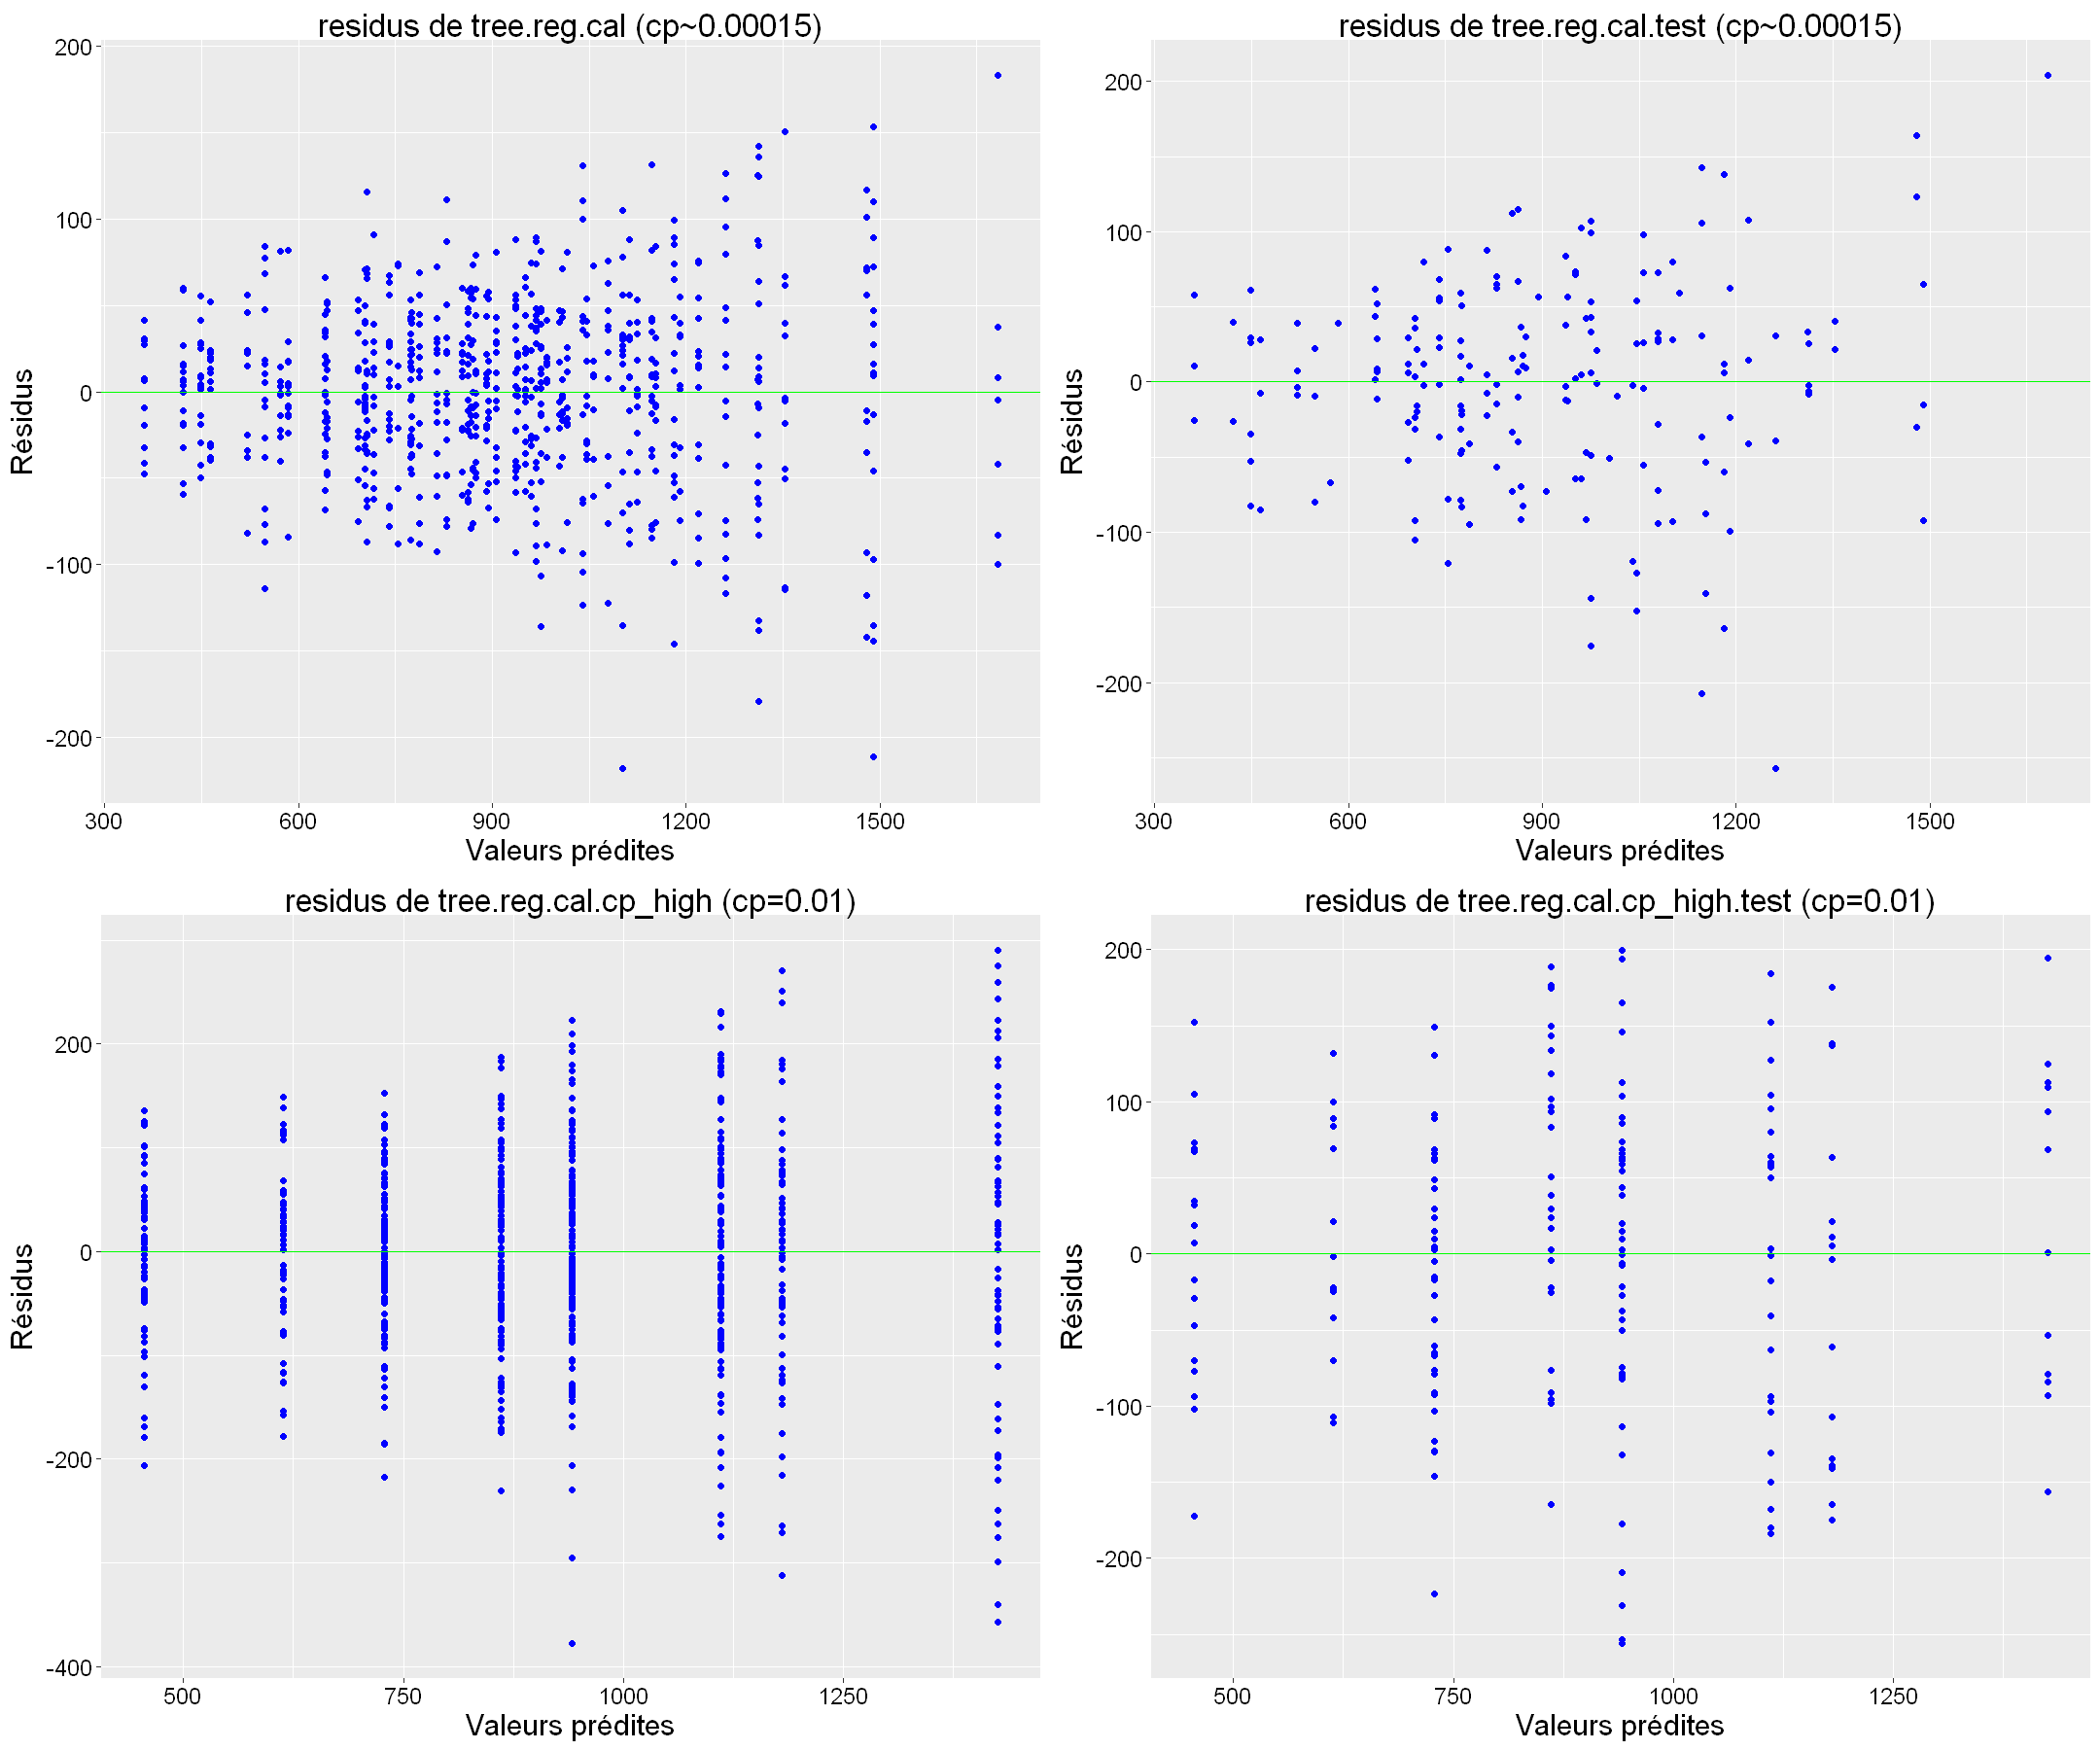

In [127]:
options(repr.plot.width=18, repr.plot.height=15)

fit.tree.cal=predict(tree.reg.cal)
res.tree.cal=fit.tree.cal-gym_train[,"Calories_Burned"]
p1 <- gplot.res(fit.tree.cal,res.tree.cal,"residus de tree.reg.cal (cp~0.00015)")

fit.tree.cal.test=predict(tree.reg.cal, newdata=gym_test)
res.tree.cal.test=fit.tree.cal.test-gym_test[,"Calories_Burned"]
p2 <- gplot.res(fit.tree.cal.test,res.tree.cal.test,"residus de tree.reg.cal.test (cp~0.00015)")

# Create a tree with lower complexity parameter (cp)
tree.reg.cal.cp_high <- rpart(Calories_Burned ~ ., data = gym_train, control=rpart.control(cp=0.01))

fit.tree.cal.cp_high=predict(tree.reg.cal.cp_high)
res.tree.cal.cp_high=fit.tree.cal.cp_high-gym_train[,"Calories_Burned"]
p3 <- gplot.res(fit.tree.cal.cp_high,res.tree.cal.cp_high,"residus de tree.reg.cal.cp_high (cp=0.01)")
fit.tree.cal.cp_high.test=predict(tree.reg.cal.cp_high, newdata=gym_test)
res.tree.cal.cp_high.test=fit.tree.cal.cp_high.test-gym_test[,"Calories_Burned"]
p4 <- gplot.res(fit.tree.cal.cp_high.test,res.tree.cal.cp_high.test,"residus de tree.reg.cal.cp_high.test (cp=0.01)")

grid.arrange(p1, p2, p3, p4, ncol = 2)
rm(p1, p2, p3, p4)

In [128]:
# Calculate metrics for tree.reg.cal
mse_train_cal <- mean(res.tree.cal^2)
r2_train_cal <- 1 - mean(res.tree.cal^2) / var(gym_train[,"Calories_Burned"])

res.tree.cal.test <- predict(tree.reg.cal, newdata = gym_test)
mse_test_cal <- mean((res.tree.cal.test - gym_test[,"Calories_Burned"])^2)
rss_cal <- sum((res.tree.cal.test - gym_test[,"Calories_Burned"])^2)
tss_cal <- sum((gym_test[,"Calories_Burned"] - mean(gym_test[,"Calories_Burned"]))^2)
r2_test_cal <- 1 - rss_cal / tss_cal

# Calculate metrics for tree.reg.cal.cp_high
mse_train_cal_cp_high <- mean(res.tree.cal.cp_high^2)
r2_train_cal_cp_high <- 1 - mean(res.tree.cal.cp_high^2) / var(gym_train[,"Calories_Burned"])

res.tree.cal.cp_high.test <- predict(tree.reg.cal.cp_high, newdata = gym_test)
mse_test_cal_cp_high <- mean((res.tree.cal.cp_high.test - gym_test[,"Calories_Burned"])^2)
rss_cal_cp_high <- sum((res.tree.cal.cp_high.test - gym_test[,"Calories_Burned"])^2)
tss_cal_cp_high <- sum((gym_test[,"Calories_Burned"] - mean(gym_test[,"Calories_Burned"]))^2)
r2_test_cal_cp_high <- 1 - rss_cal_cp_high / tss_cal_cp_high

# Create a summary table
results <- data.frame(
    Model = c("tree.reg.cal", "tree.reg.cal.cp_high"),
    MSE_Train = c(mse_train_cal, mse_train_cal_cp_high),
    MSE_Test = c(mse_test_cal, mse_test_cal_cp_high),
    R2_Train = c(r2_train_cal, r2_train_cal_cp_high),
    R2_Test = c(r2_test_cal, r2_test_cal_cp_high)
)

# Print the table
print(results)


                 Model MSE_Train  MSE_Test  R2_Train   R2_Test
1         tree.reg.cal  2613.292  4521.336 0.9655021 0.9339557
2 tree.reg.cal.cp_high  9733.390 10097.079 0.8715101 0.8525094


**Interprétation** : Le modèle complexe (`cp = 0.00015`) montre des résidus mieux centrés et moins dispersés que le modèle élagué (`cp = 0.01`), avec des métriques favorables (R²_test = 0.934 vs 0.853). Toutefois, ces résultats masquent deux risques critiques :
1. Strucutre instable : Une légère perturbation des données pourrait altérer radicalement la structure et la hierarchie des nœuds,
2. Robustesse incertaine : La performance pourrait se dégrader sur des jeux de données déséquilibrés ou non stationnaires.

Pour lever ces doutes, une validation complémentaire par bootstrap (échantillonnage Monte Carlo) serait nécessaire afin d'étudier la variabilité des partitions de l'arbre.

**Bilan** :
Ces résultats paradoxaux – un modèle clairement surappris mais conservant un pouvoir prédictif élevé – suggère deux hypothèses : 
1. Signal fort dans les données : Les variables explicatives contiennent des relations structurelles robustes (linéaires ou non-linéaires), partiellement généralisables même avec un arbre sur-adapté.  
2. Limites du sur-apprentissage arborescent : Contrairement à d’autres méthodes (ex : réseaux de neurones), les arbres surappris peuvent rester partiellement interprétables et éviter un effondrement complet en généralisation. 

Néanmoins, la supériorité du modèle linéaire (R²_test = 0.98) remet en question la pertinence de la complexité arborescente. Si la relation sous-jacente est majoritairement linéaire, l’arbre introduit un biais de variance inutile. Cette observation plaide pour une analyse comparative approfondie entre modèles linéaires et non linéaires.

Pour conclure, bien que l’arbre complexe ne soit pas optimal (sur-apprentissage avéré et performance inférieure au linéaire), sa robustesse relative en généralisation (R²_test = 0.93) souligne la présence de motifs prédictifs stables dans les données. Ce résultat justifie une exploration des méthodes hybrides (ex : forêts aléaires avec régularisation, XGBoost) pour concilier flexibilité non linéaire et stabilité.

### Regularization (pruning trees)

### Random Forests
- Using Bootsratp
- **plot** feature importance

### XGBoost
- Optimize number of trees and learning rate.
- Use early stopping to prevent overfitting.
- Plot: SHAP values for interpretability.